In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os
import joblib
import cv2
import seaborn as sns
sns.set_style('darkgrid')
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('cervical-cancer_csv.csv')
df.head(10)

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.000000,37.0,1.0,3.0,0.0,...,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.000000,0.0,1.0,15.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
5,42,3.0,23.0,2.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
6,51,3.0,17.0,6.0,1.0,34.000000,3.4,0.0,0.0,1.0,...,NaN,NaN,0,0,0,0,1,1,0,1
7,26,1.0,26.0,3.0,0.0,0.000000,0.0,1.0,2.0,1.0,...,NaN,NaN,0,0,0,0,0,0,0,0
8,45,1.0,20.0,5.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,1,0,1,1,0,0,0,0
9,44,3.0,15.0,NaN,1.0,1.266973,2.8,0.0,0.0,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0


In [5]:
X = df.drop('Biopsy', axis =1).apply(pd.to_numeric, errors='coerce').astype('float64')
y = df["Biopsy"]
sm = SMOTE(random_state=42)
X,y = sm.fit_resample(X, y.ravel())
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 2021, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


# Building, Compiling, and Training ANN Model

In [6]:
#Imports Tensorflow and create a Sequential Model to add layer for the ANN
ann = tf.keras.models.Sequential()
#Input layer
ann.add(tf.keras.layers.Dense(units=500,input_dim=33,kernel_initializer='uniform',activation='relu'))
ann.add(tf.keras.layers.Dropout(0.5))
#Hidden layer 1
ann.add(tf.keras.layers.Dense(units=200, kernel_initializer='uniform',activation='relu'))
ann.add(tf.keras.layers.Dropout(0.5))
#Output layer
ann.add(tf.keras.layers.Dense(units=1,kernel_initializer='uniform',activation='sigmoid'))
print(ann.summary()) #for showing the structure and parameters
#Compiles the ANN using ADAM optimizer.
ann.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics = ['accuracy'])
#Trains the ANN with 100 epochs.
history = ann.fit(X_train, y_train, batch_size = 64,validation_split=0.20, epochs = 250, shuffle=True)
#Saves model
ann.save('cervical_model.h5')
#Saves history into npy file
np.save('cervical_history.npy', history.history)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               17000     
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               100200    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 117401 (458.60 KB)
Trainable params: 117401 (458.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/250

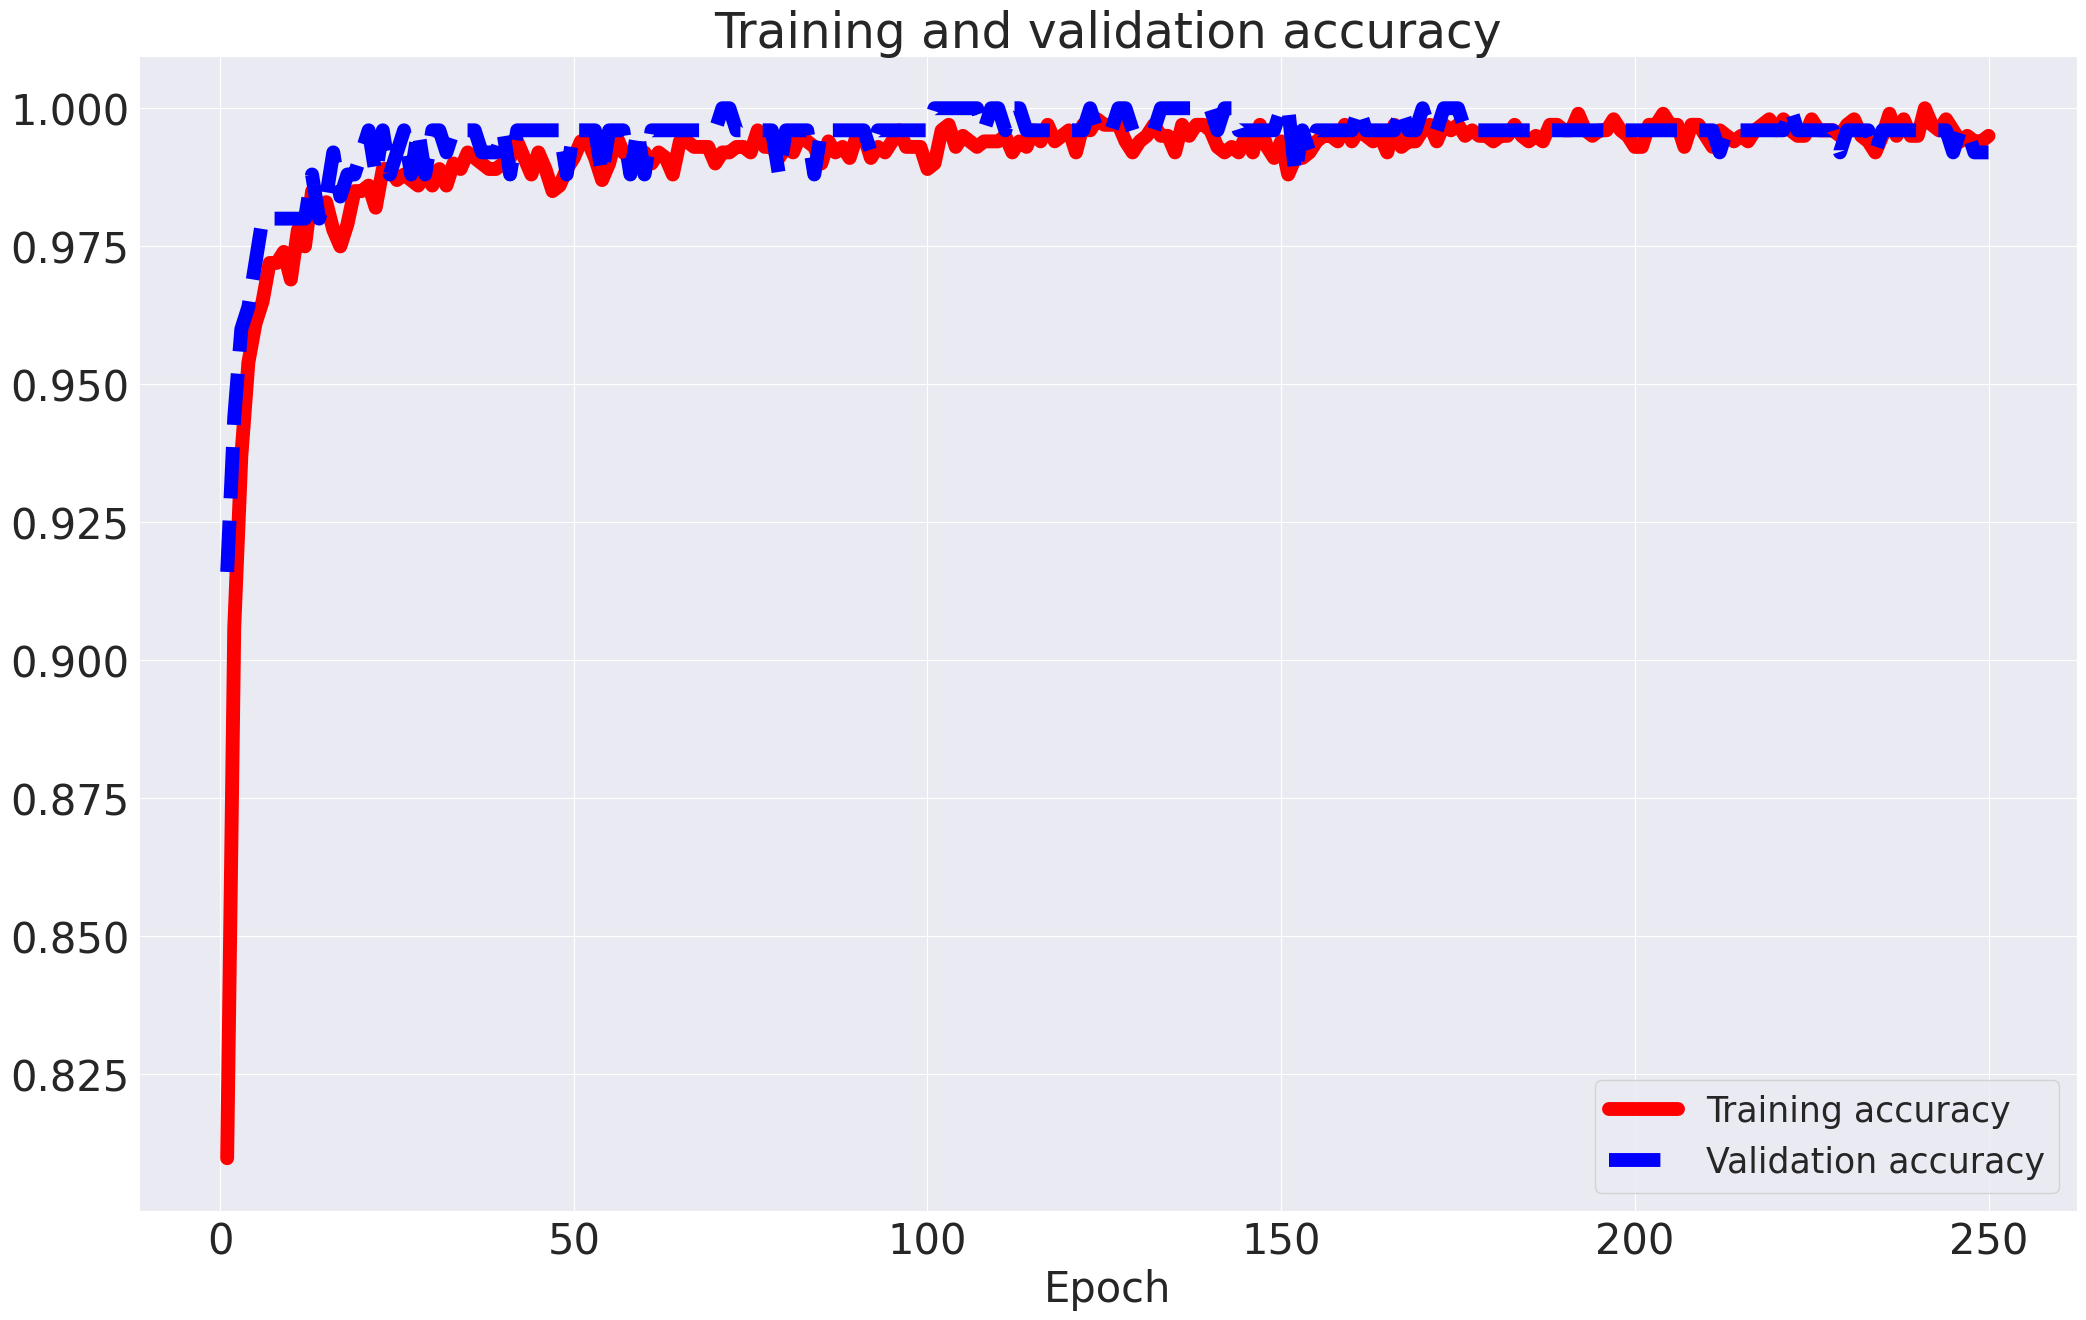

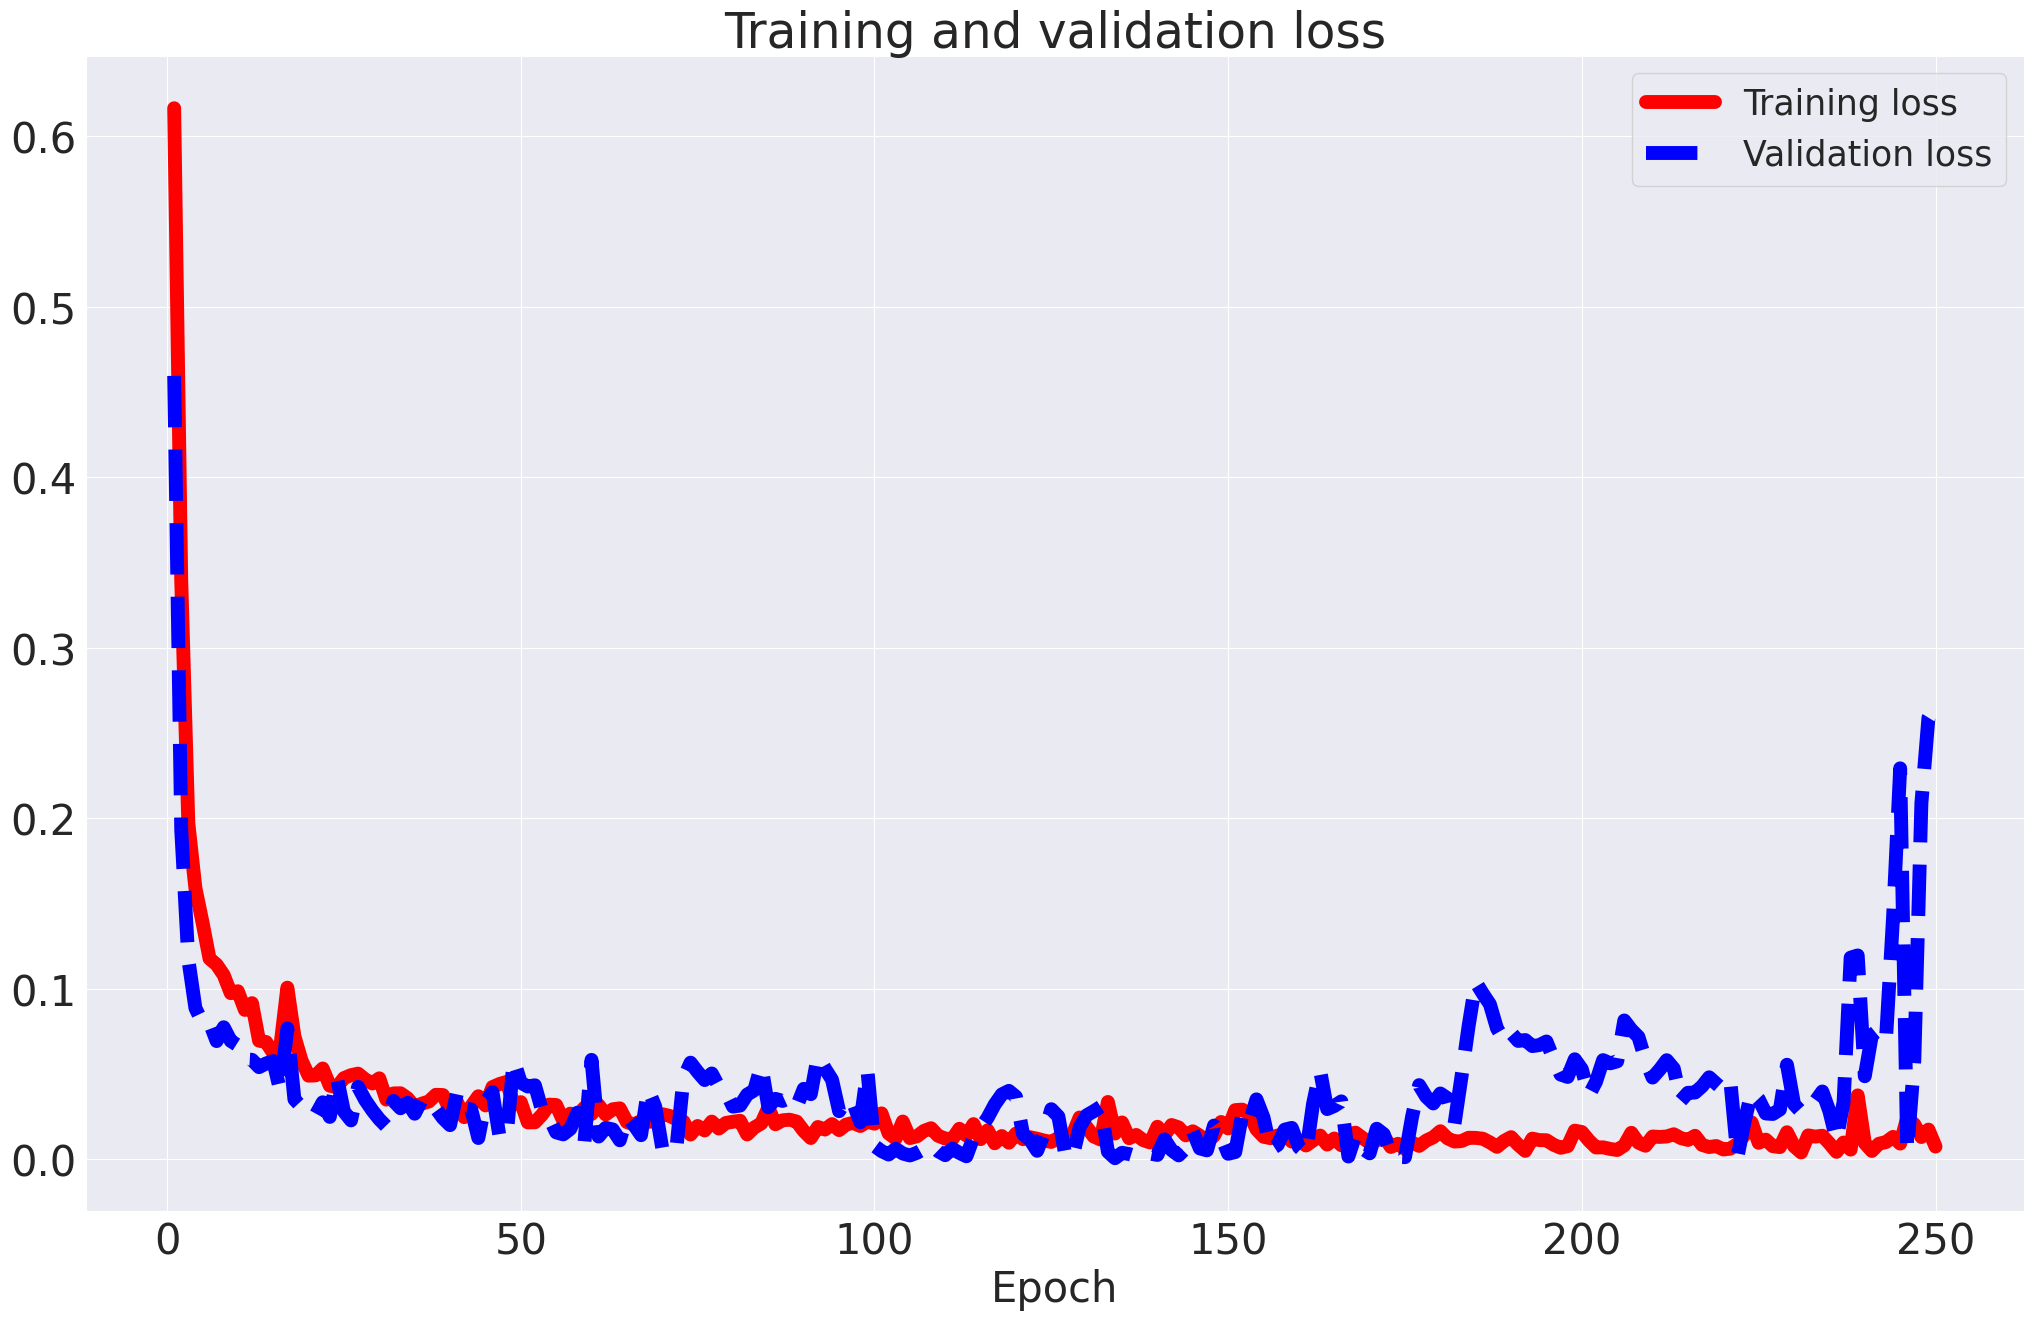

In [7]:
#Plots accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#accuracy
fig, ax = plt.subplots(figsize=(25, 15))
plt.plot(epochs, acc, 'r', label='Training accuracy',lw=10)
plt.plot(epochs, val_acc, 'b--', label='Validation accuracy', lw=10)
plt.title('Training and validation accuracy',fontsize=35)
plt.legend(fontsize=25)
ax.set_xlabel("Epoch", fontsize=30)
ax.tick_params(labelsize=30)
plt.show()
#loss
fig, ax = plt.subplots(figsize=(25, 15))
plt.plot(epochs, loss, 'r', label='Training loss', lw=10)
plt.plot(epochs, val_loss, 'b--', label='Validation loss',lw=10)
plt.title('Training and validation loss', fontsize=35)
plt.legend(fontsize=25)
ax.set_xlabel("Epoch", fontsize=30)
ax.tick_params(labelsize=30)
plt.show()

In [9]:
#Performance Evaluation - Accuracy and Classification Report
#Accuracy Score
print ('Accuracy Score : ', accuracy_score(y_pred, y_test, normalize=True), '\n')
#precision, recall report
print ('Classification Report :\n\n' ,classification_report(y_pred, y_test))

Accuracy Score :  0.987220447284345 

Classification Report :

               precision    recall  f1-score   support

           0       0.98      0.99      0.99       155
           1       0.99      0.98      0.99       158

    accuracy                           0.99       313
   macro avg       0.99      0.99      0.99       313
weighted avg       0.99      0.99      0.99       313



[Text(0, 0.5, 'Biopsy = 0'), Text(0, 1.5, 'Biopsy = 1')]

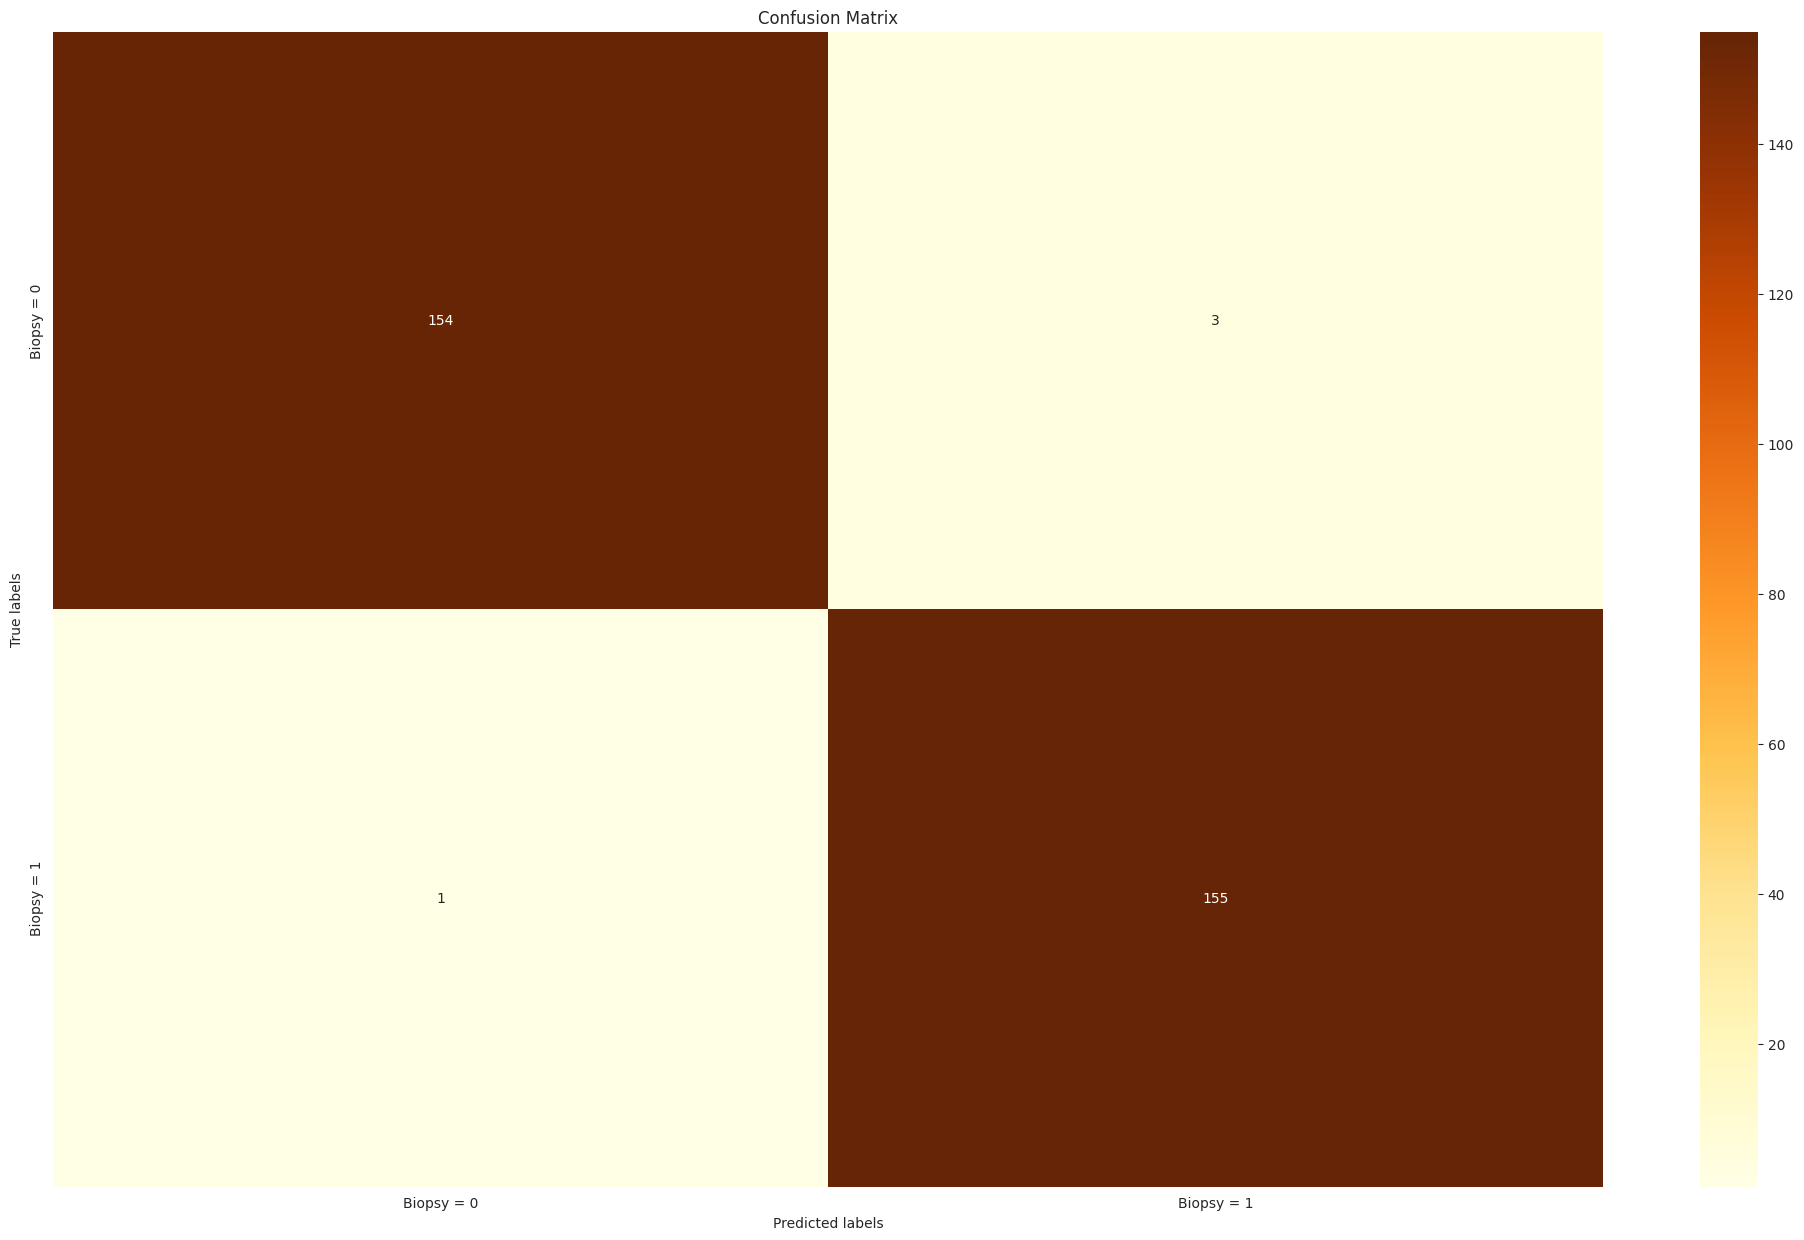

In [10]:
#Confusion matrix:
conf_mat = confusion_matrix(y_true=y_test, y_pred = y_pred)
class_list = ['Biopsy = 0', 'Biopsy = 1']
fig, ax = plt.subplots(figsize=(25, 15))
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax,cmap='YlOrBr', fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(class_list),
ax.yaxis.set_ticklabels(class_list)


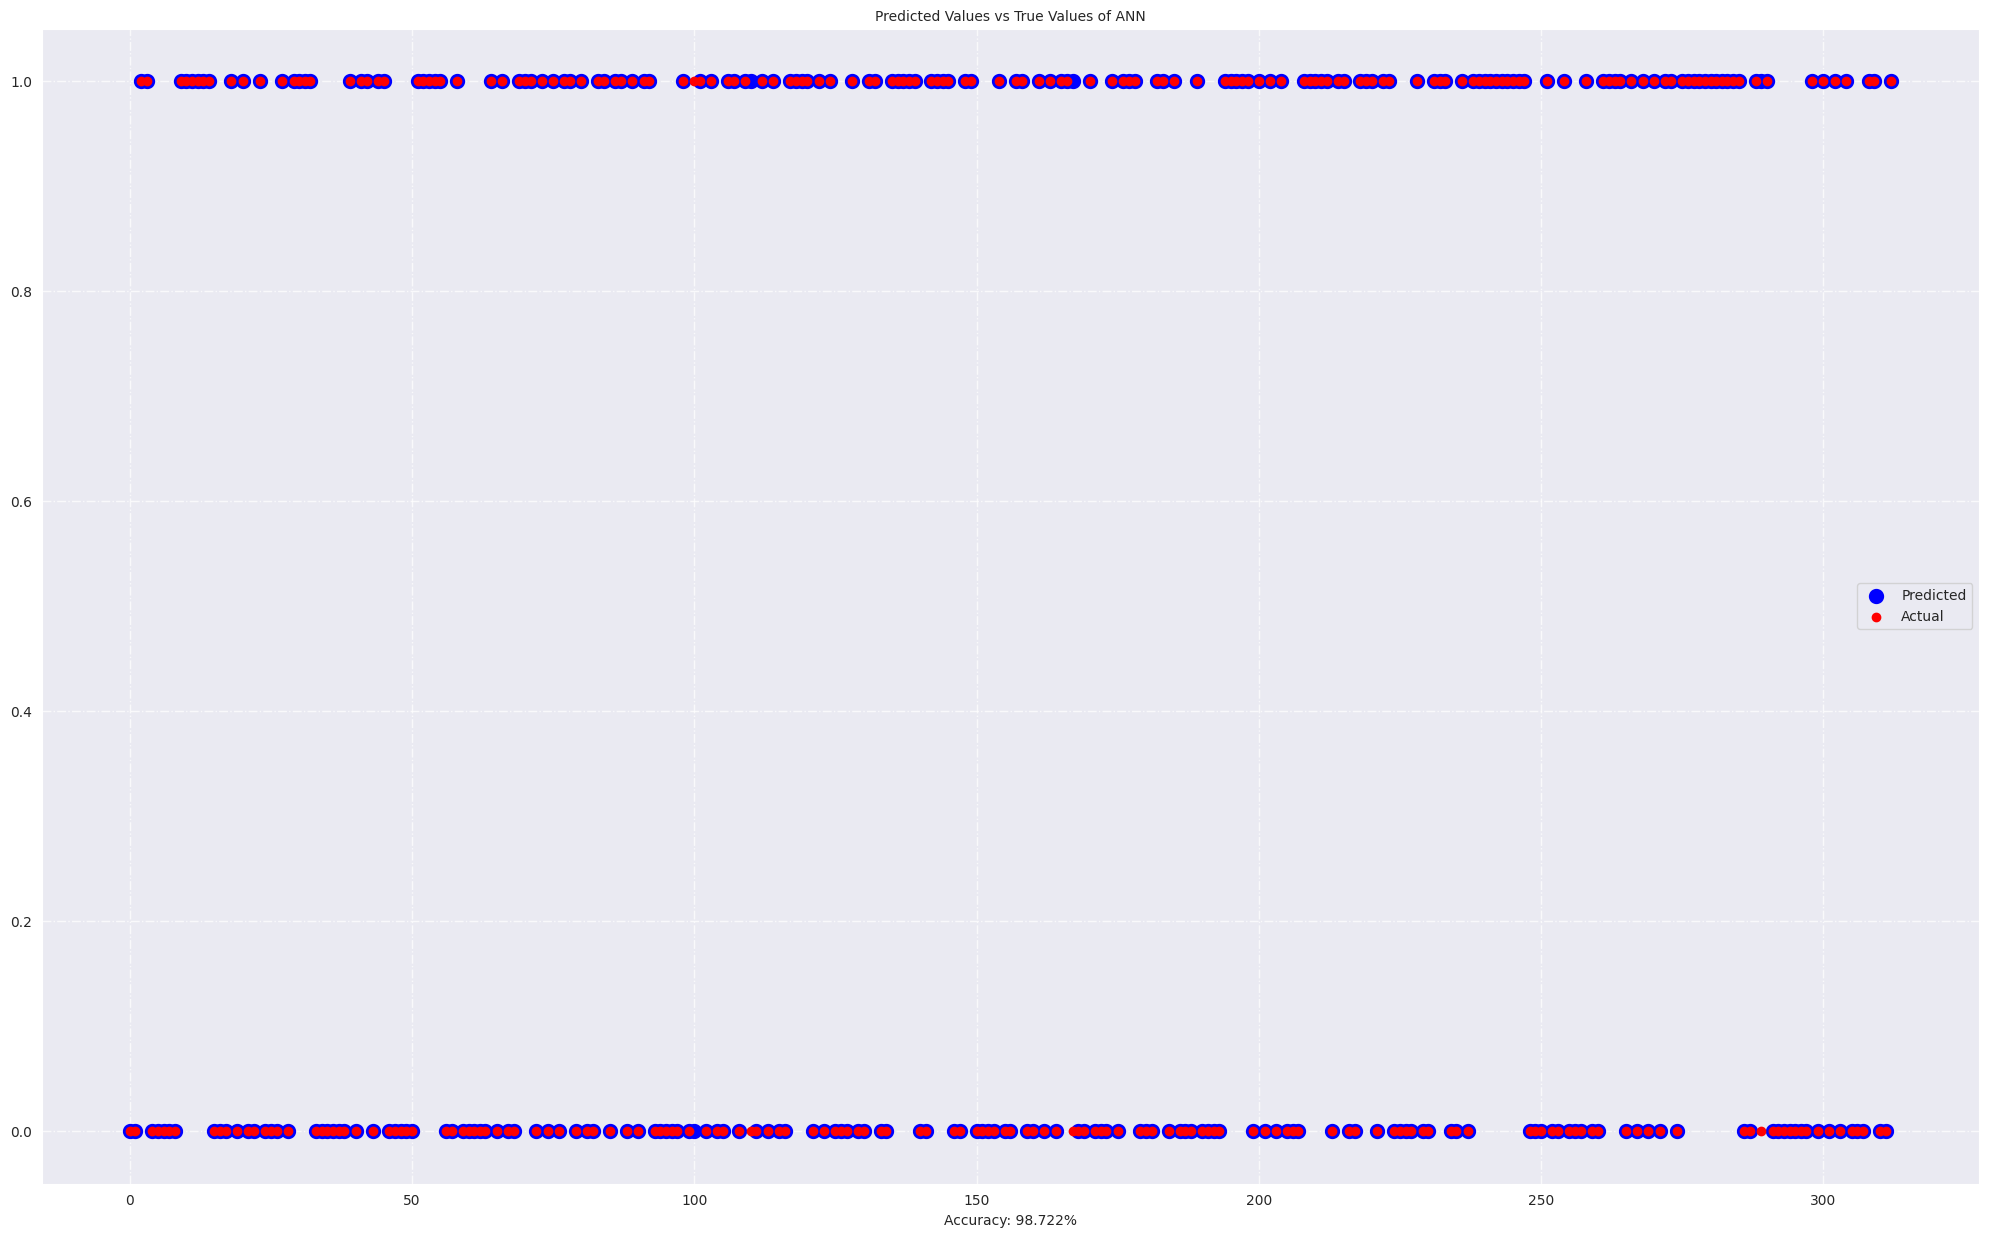

In [11]:
def plot_real_pred_val(Y_test, ypred, name):
    plt.figure(figsize=(25,15))
    acc=accuracy_score(Y_test,ypred)
    plt.scatter(range(len(ypred)),ypred,color="blue",lw=5,label="Predicted")
    plt.scatter(range(len(Y_test)),Y_test,color="red",label="Actual")
    plt.title("Predicted Values vs True Values of " + name, fontsize=10)
    plt.xlabel("Accuracy: " + str(round((acc*100),3)) +"%")
    plt.legend()
    plt.grid(True, alpha=0.75, lw=1, ls='-.')
    plt.show()
plot_real_pred_val(y_test, y_pred, 'ANN')


# Cervical Cancer Using LSTM Model

In [12]:
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
2,34,1.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0


In [13]:
X = df.drop('Biopsy', axis =1).apply(pd.to_numeric, errors='coerce').astype('float64')
y = df["Biopsy"]
sm = SMOTE(random_state=42)
X,y = sm.fit_resample(X, y.ravel())
#Splits the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 2021, stratify=y)
#Standar scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [14]:
# Reshape the data for LSTM input
X_train = X_train.reshape(X_train.shape[0], 1,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1,X_test.shape[1])
# Create an LSTM model
lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])),
 tf.keras.layers.Dropout(0.5),
 tf.keras.layers.Dense(units=1,activation='sigmoid')
])
print(lstm_model.summary()) # Display the model summary
# Compile the LSTM model
lstm_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
# Train the LSTM model
history = lstm_model.fit(X_train, y_train,
batch_size=64, validation_split=0.20, epochs=250,
shuffle=True)
# Save the LSTM model
lstm_model.save('cervical_lstm_model.h5')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                25088     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 25153 (98.25 KB)
Trainable params: 25153 (98.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/250
16/16 [==============================] - 4s 44ms/step - loss: 0.6785 - accuracy: 0.5536 - val_loss: 0.6431 - val_accuracy: 0.6920
Epoch 2/250
16/16 [==============================] - 0s 6ms/step - loss: 0.6161 - accuracy: 0.7307 - val_loss: 0.5891 - val_accuracy: 0

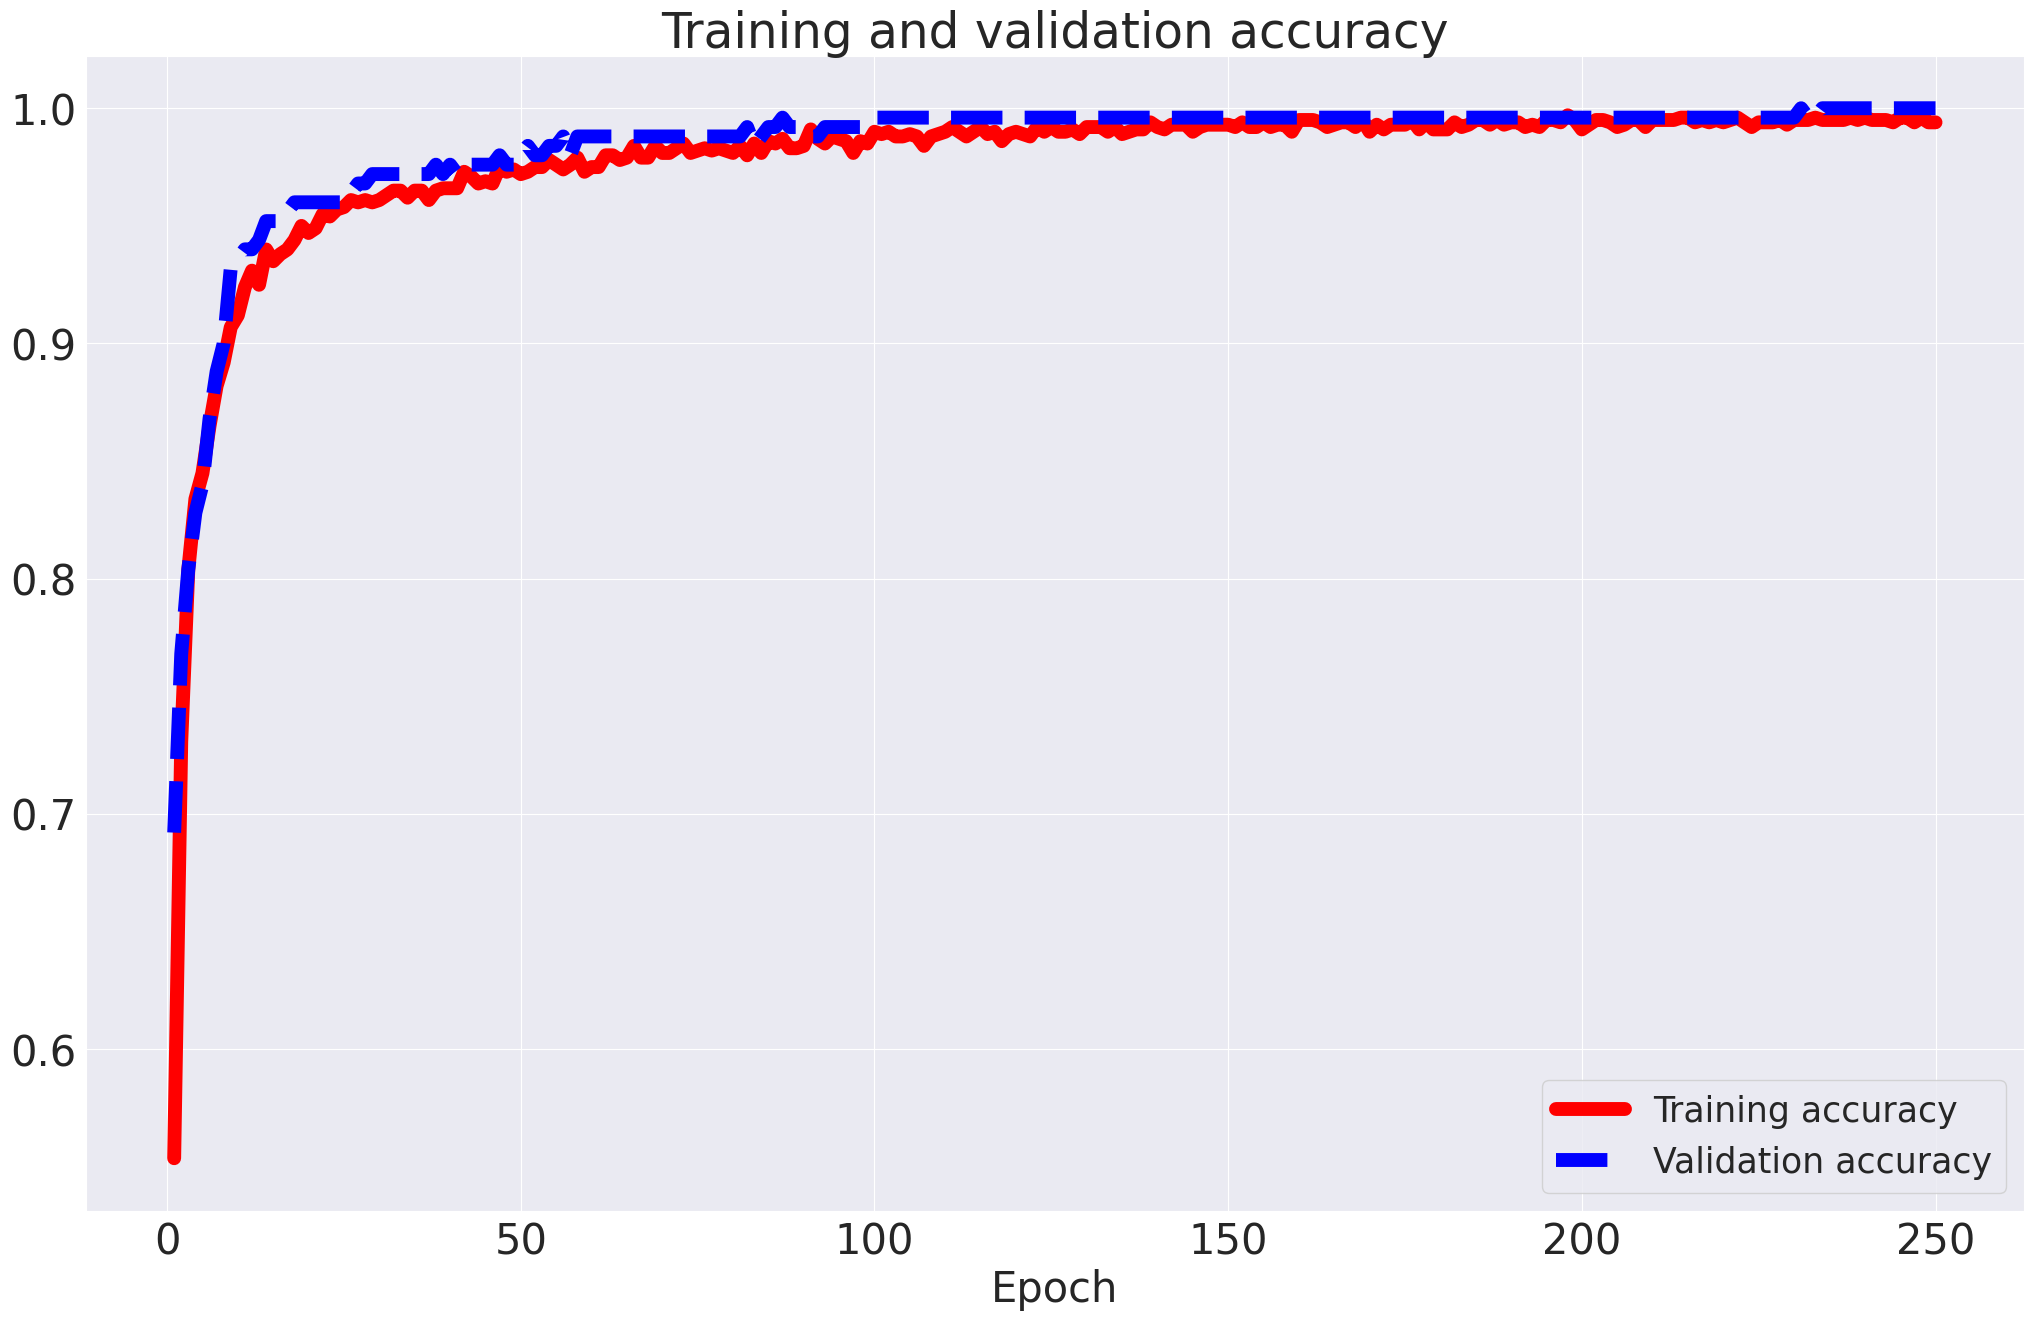

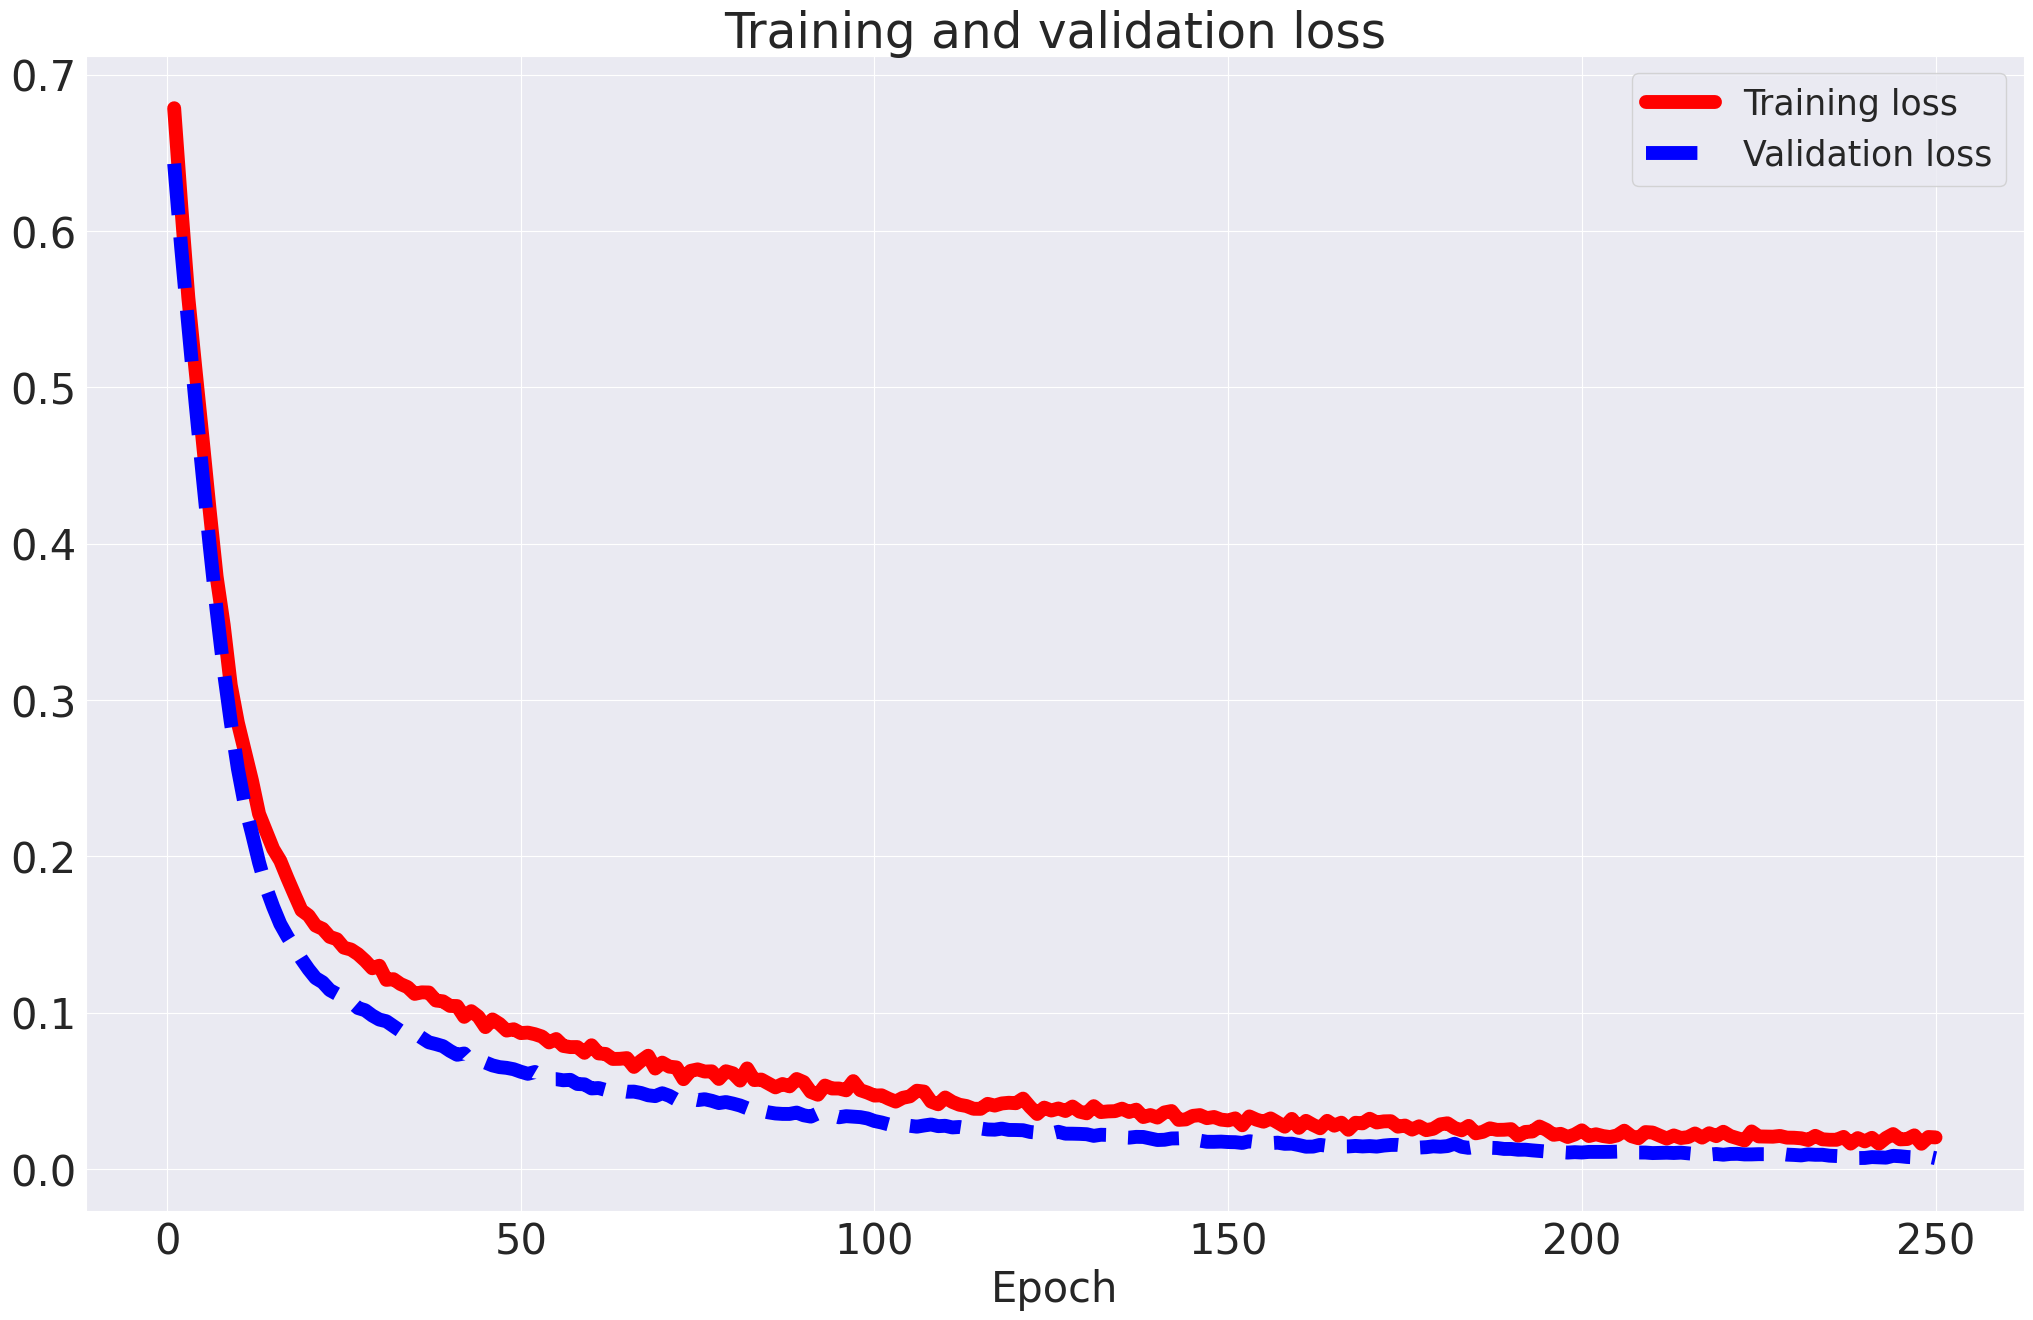

10/10 [==============================] - 0s 2ms/step
[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Accurac

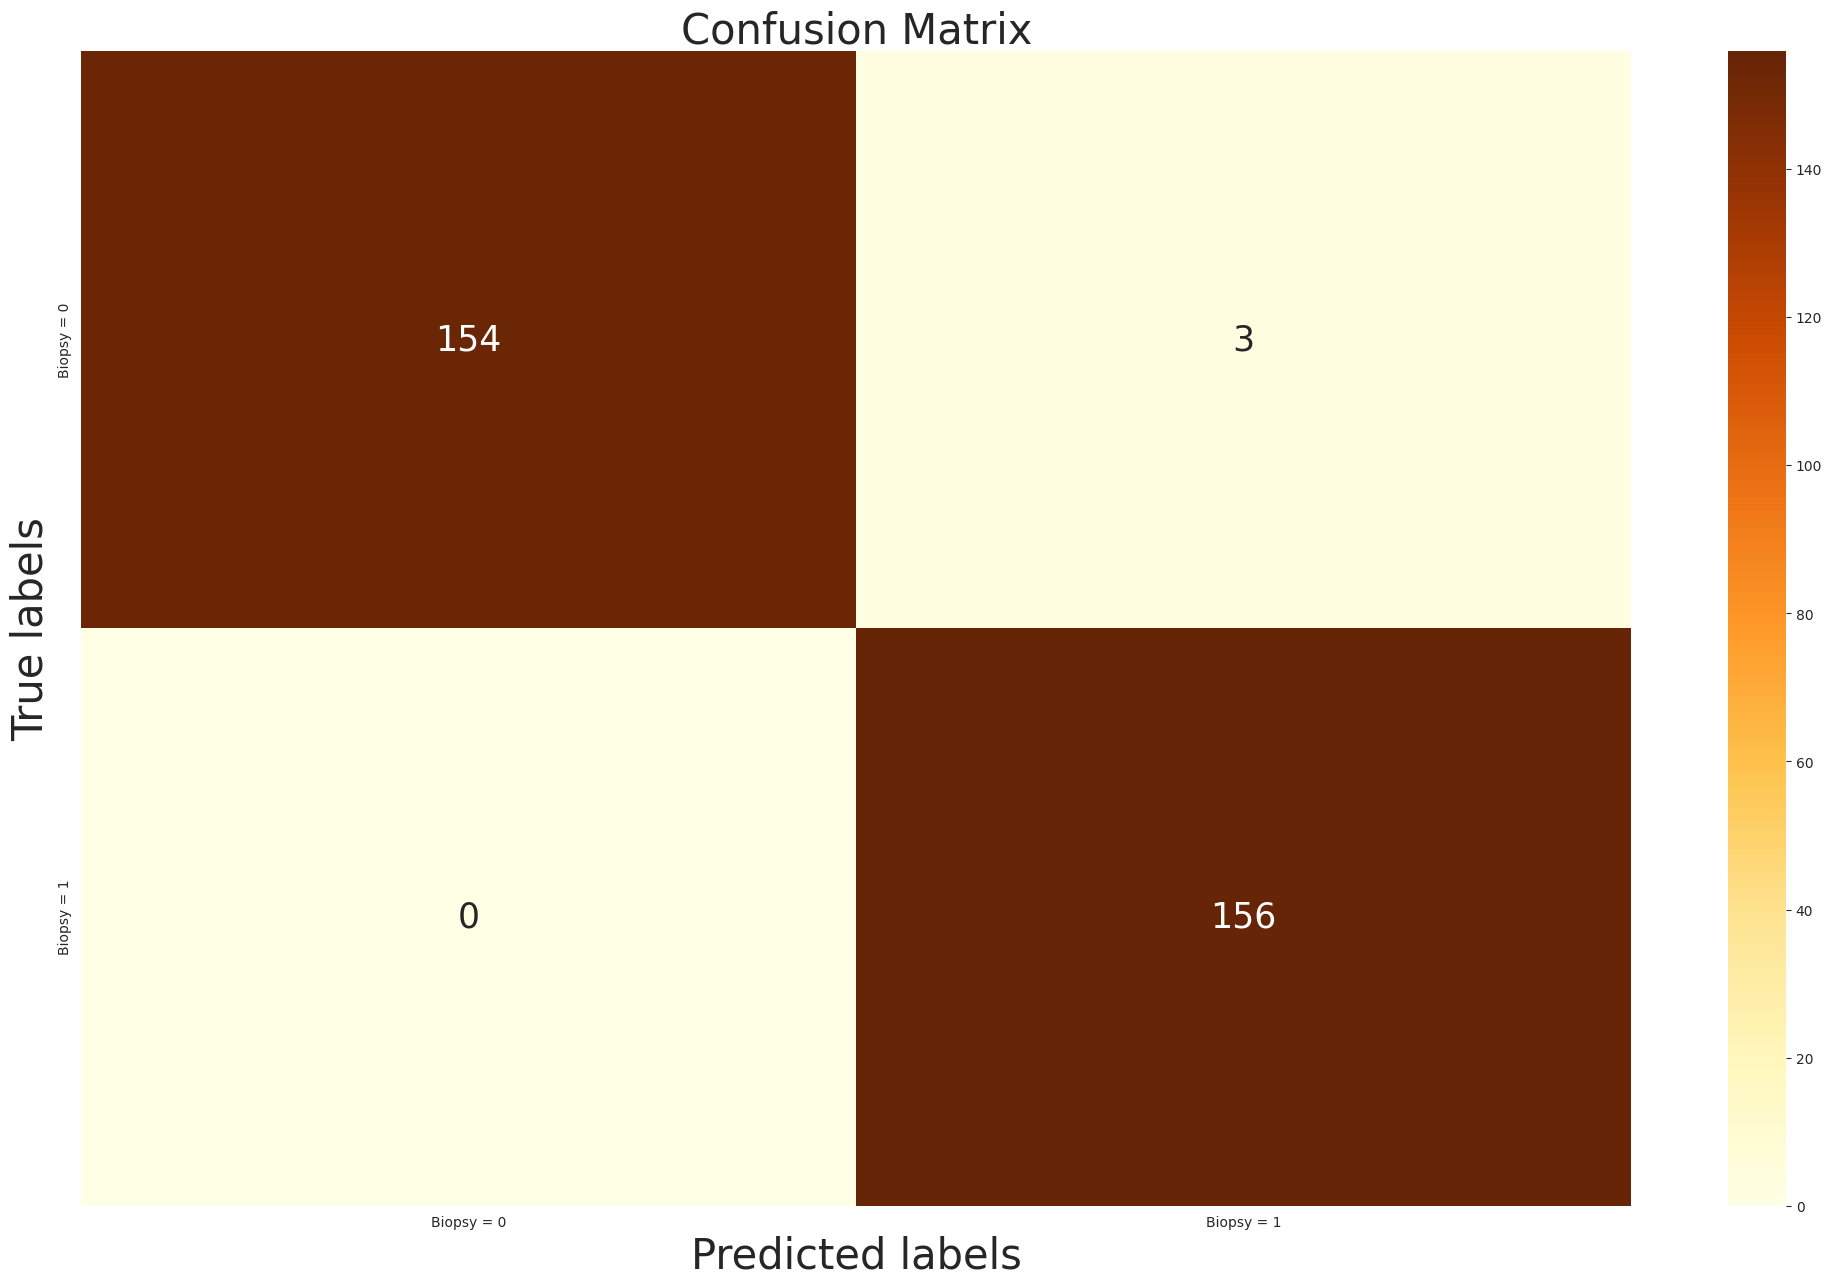

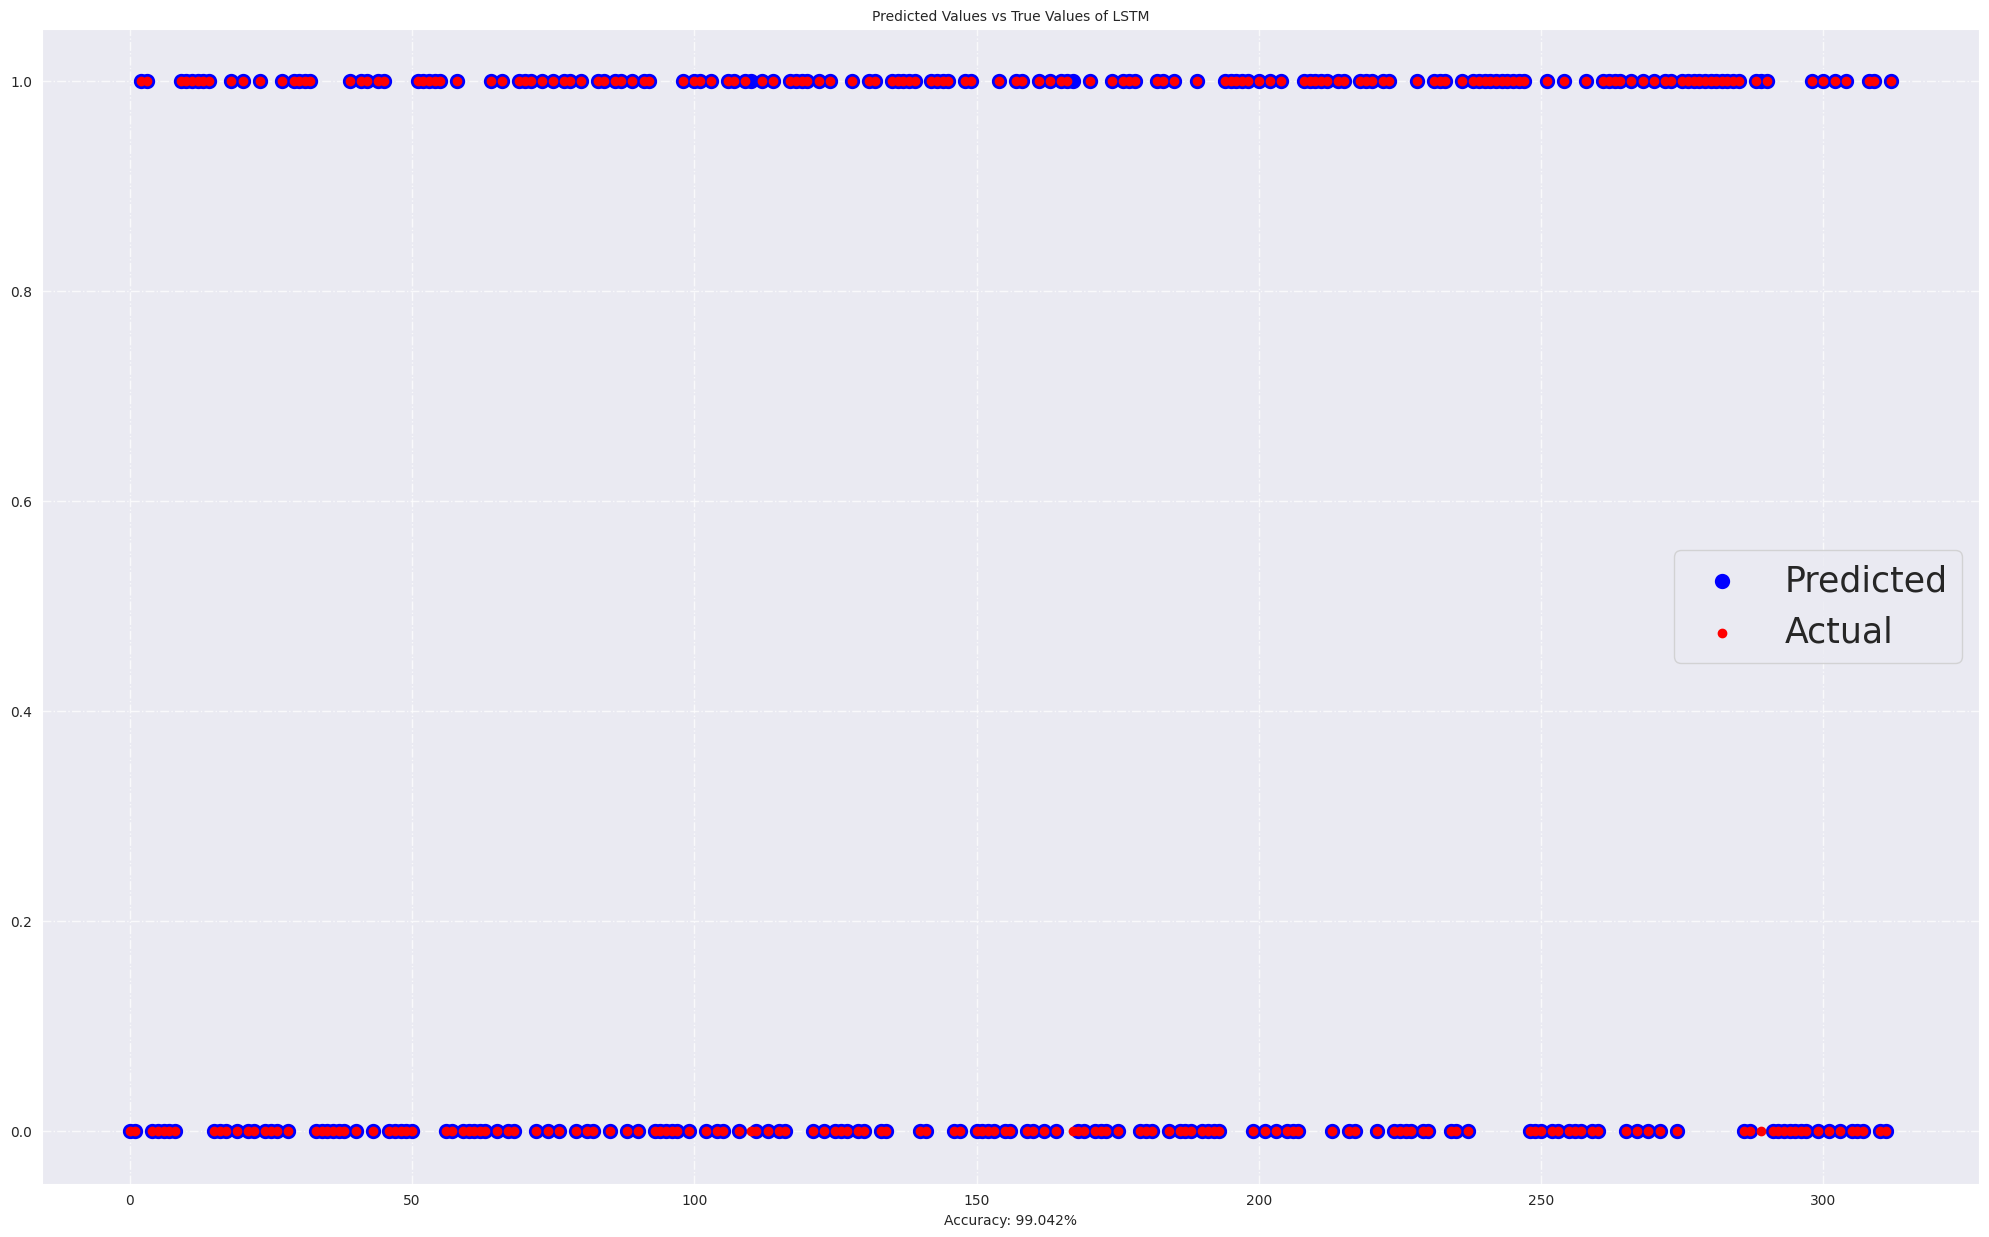

In [15]:
#Plots accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#accuracy
fig, ax = plt.subplots(figsize=(25, 15))
plt.plot(epochs, acc, 'r', label='Training accuracy', lw=10)
plt.plot(epochs, val_acc, 'b--', label='Validation accuracy', lw=10)
plt.title('Training and validation accuracy', fontsize=35)
plt.legend(fontsize=25)
ax.set_xlabel("Epoch", fontsize=30)
ax.tick_params(labelsize=30)
plt.show()
#loss
fig, ax = plt.subplots(figsize=(25, 15))
plt.plot(epochs, loss, 'r', label='Training loss', lw=10)
plt.plot(epochs, val_loss, 'b--', label='Validation loss', lw=10)
plt.title('Training and validation loss', fontsize=35)
plt.legend(fontsize=25)
ax.set_xlabel("Epoch", fontsize=30)
ax.tick_params(labelsize=30)
plt.show()
#Sets the threshold for the predictions. In this case, the threshold is 0.5(this value can be modified).
#prediction on test set
y_pred = lstm_model.predict(X_test)
y_pred = [int(p>=0.5) for p in y_pred]
print(y_pred)
#Performance Evaluation - Accuracy and Classification Report
#Accuracy Score
print ('Accuracy Score : ', accuracy_score(y_pred, y_test,normalize=True), '\n')
#precision, recall report
print ('Classification Report :\n\n' ,classification_report(y_pred, y_test))
#Confusion matrix:
conf_mat = confusion_matrix(y_true=y_test, y_pred = y_pred)
class_list = ['Biopsy = 0', 'Biopsy = 1']
fig, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(conf_mat, annot=True, ax = ax, cmap='YlOrBr', fmt='g',annot_kws={"size": 25})
ax.set_xlabel('Predicted labels', fontsize=30)
ax.set_ylabel('True labels', fontsize=30)
ax.set_title('Confusion Matrix', fontsize=30)
ax.xaxis.set_ticklabels(class_list), ax.yaxis.set_ticklabels(class_list)
def plot_real_pred_val(Y_test, ypred, name):
    plt.figure(figsize=(25,15))
    acc=accuracy_score(Y_test,ypred)
    plt.scatter(range(len(ypred)),ypred,color="blue",lw=5,label="Predicted")
    plt.scatter(range(len(Y_test)), Y_test,color="red",label="Actual")
    plt.title("Predicted Values vs True Values of " + name, fontsize=10)
    plt.xlabel("Accuracy: " + str(round((acc*100),3)) + "%")
    plt.legend(fontsize=25)
    plt.grid(True, alpha=0.75, lw=1, ls='-.')
    plt.show()
plot_real_pred_val(y_test, y_pred, 'LSTM')


# Cervical Cancer Using Self Organizing Maps (SOMs) Model

In [16]:
!pip install MiniSom

  Preparing metadata (setup.py) ... - \ done
  Created wheel for MiniSom: filename=MiniSom-2.3.1-py3-none-any.whl size=10588 sha256=6a290130b68d0be239e89305123966fd890eb55366e62f535af1b692cf7bd762
  Stored in directory: /root/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
Successfully built MiniSom


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17152     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17217 (67.25 KB)
Trainable params: 17217 (67.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/250
9/9 [==============================] - 3s 82ms/step - loss: 0.5730 - accuracy: 0.8633 - val_loss: 0.5014 - val_accuracy: 0.9627
Epoch 2/250
9/9 [==============================] - 0s 11ms/step - loss: 0.4923 - accuracy: 0.9270 - val_loss: 0.4187 - val_accuracy: 0.96

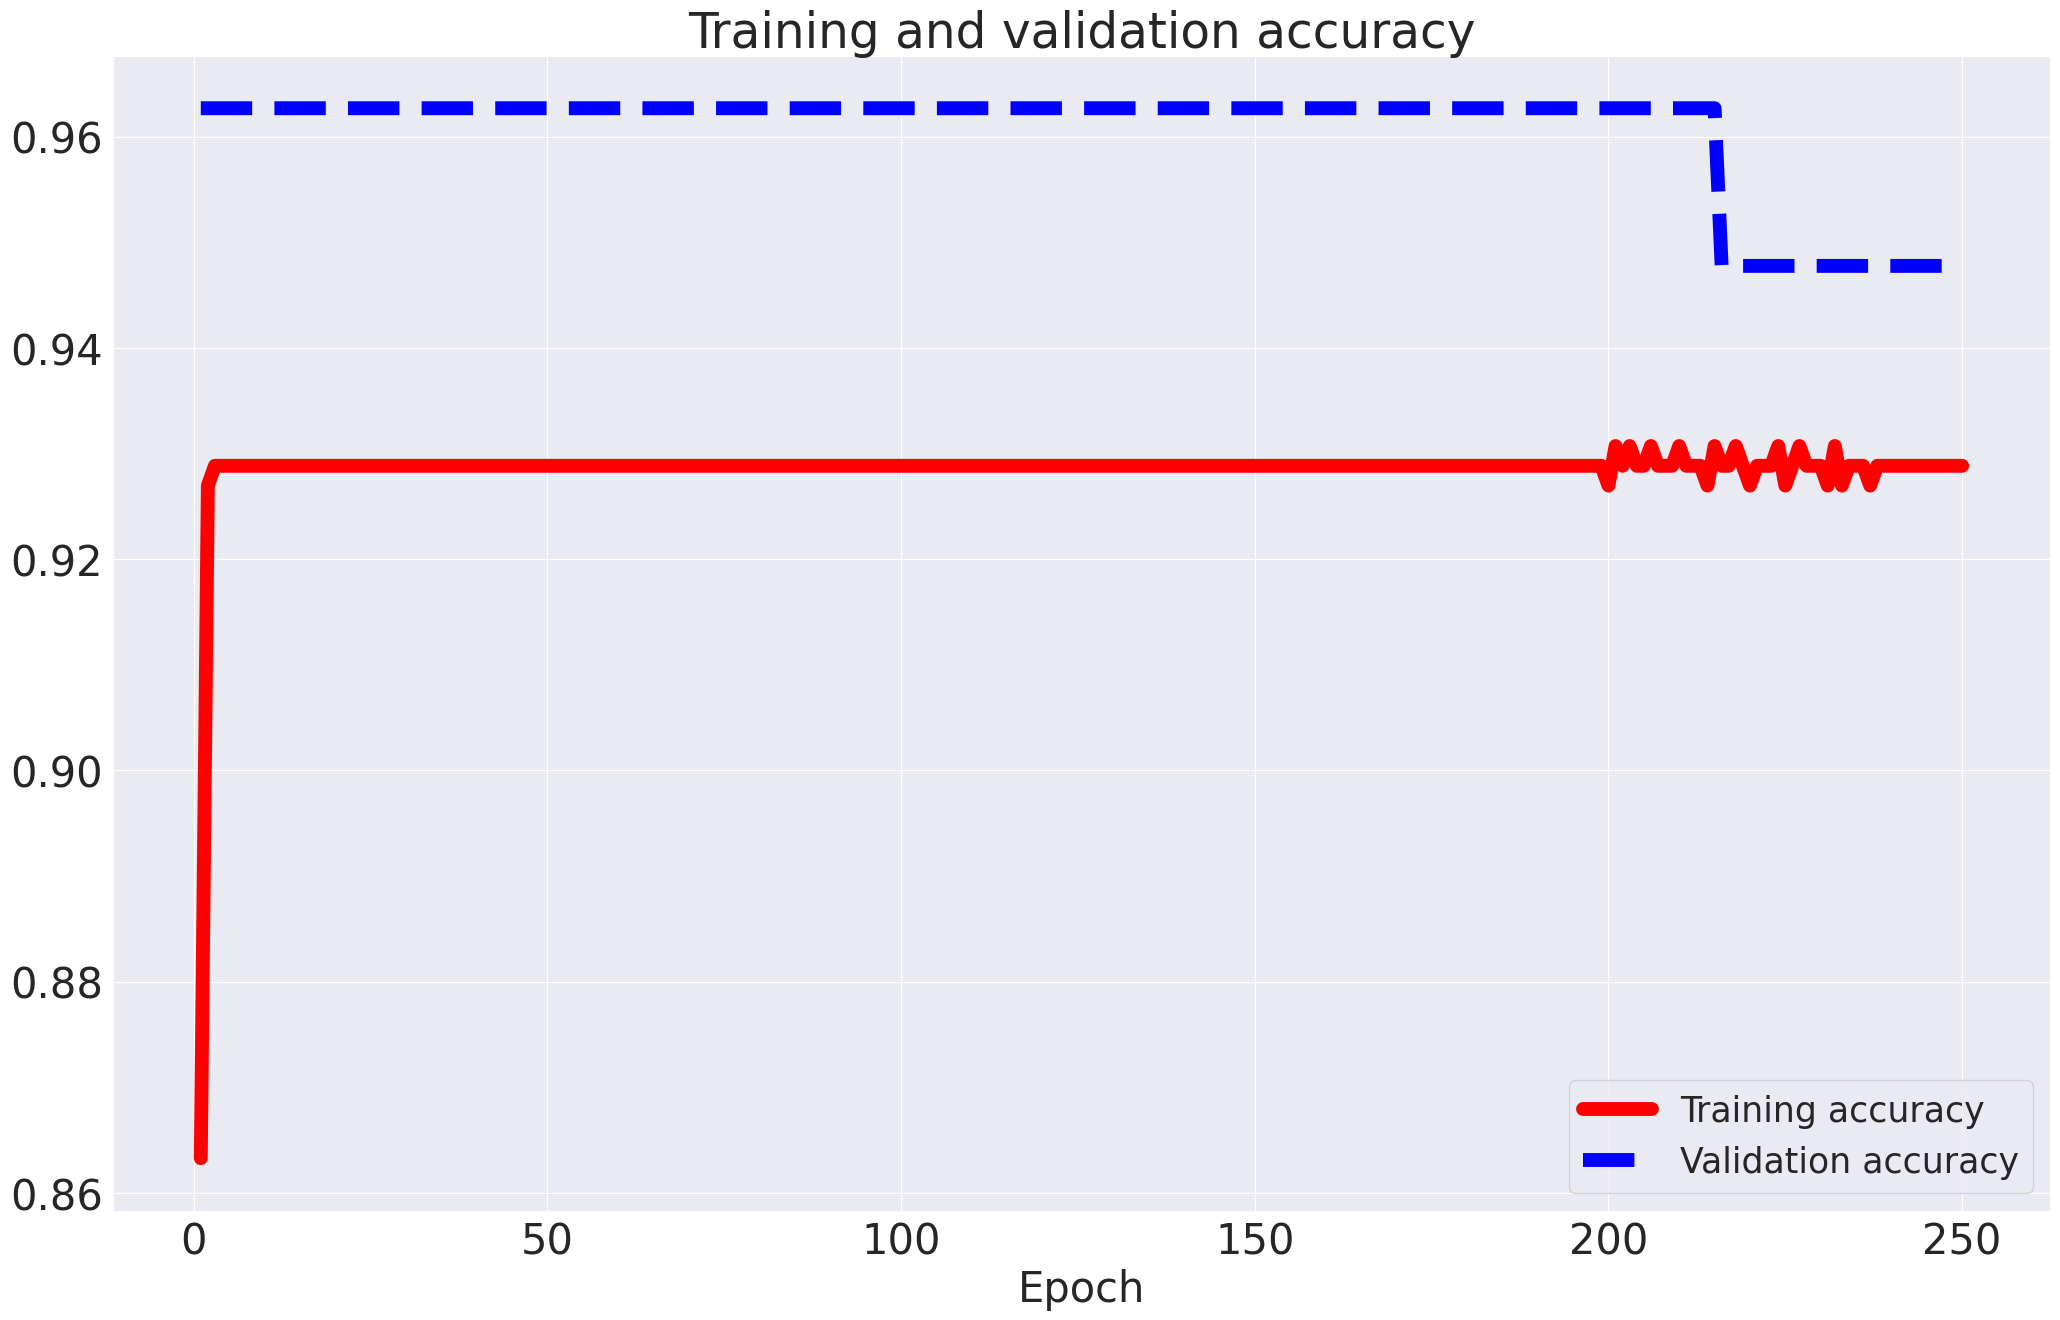

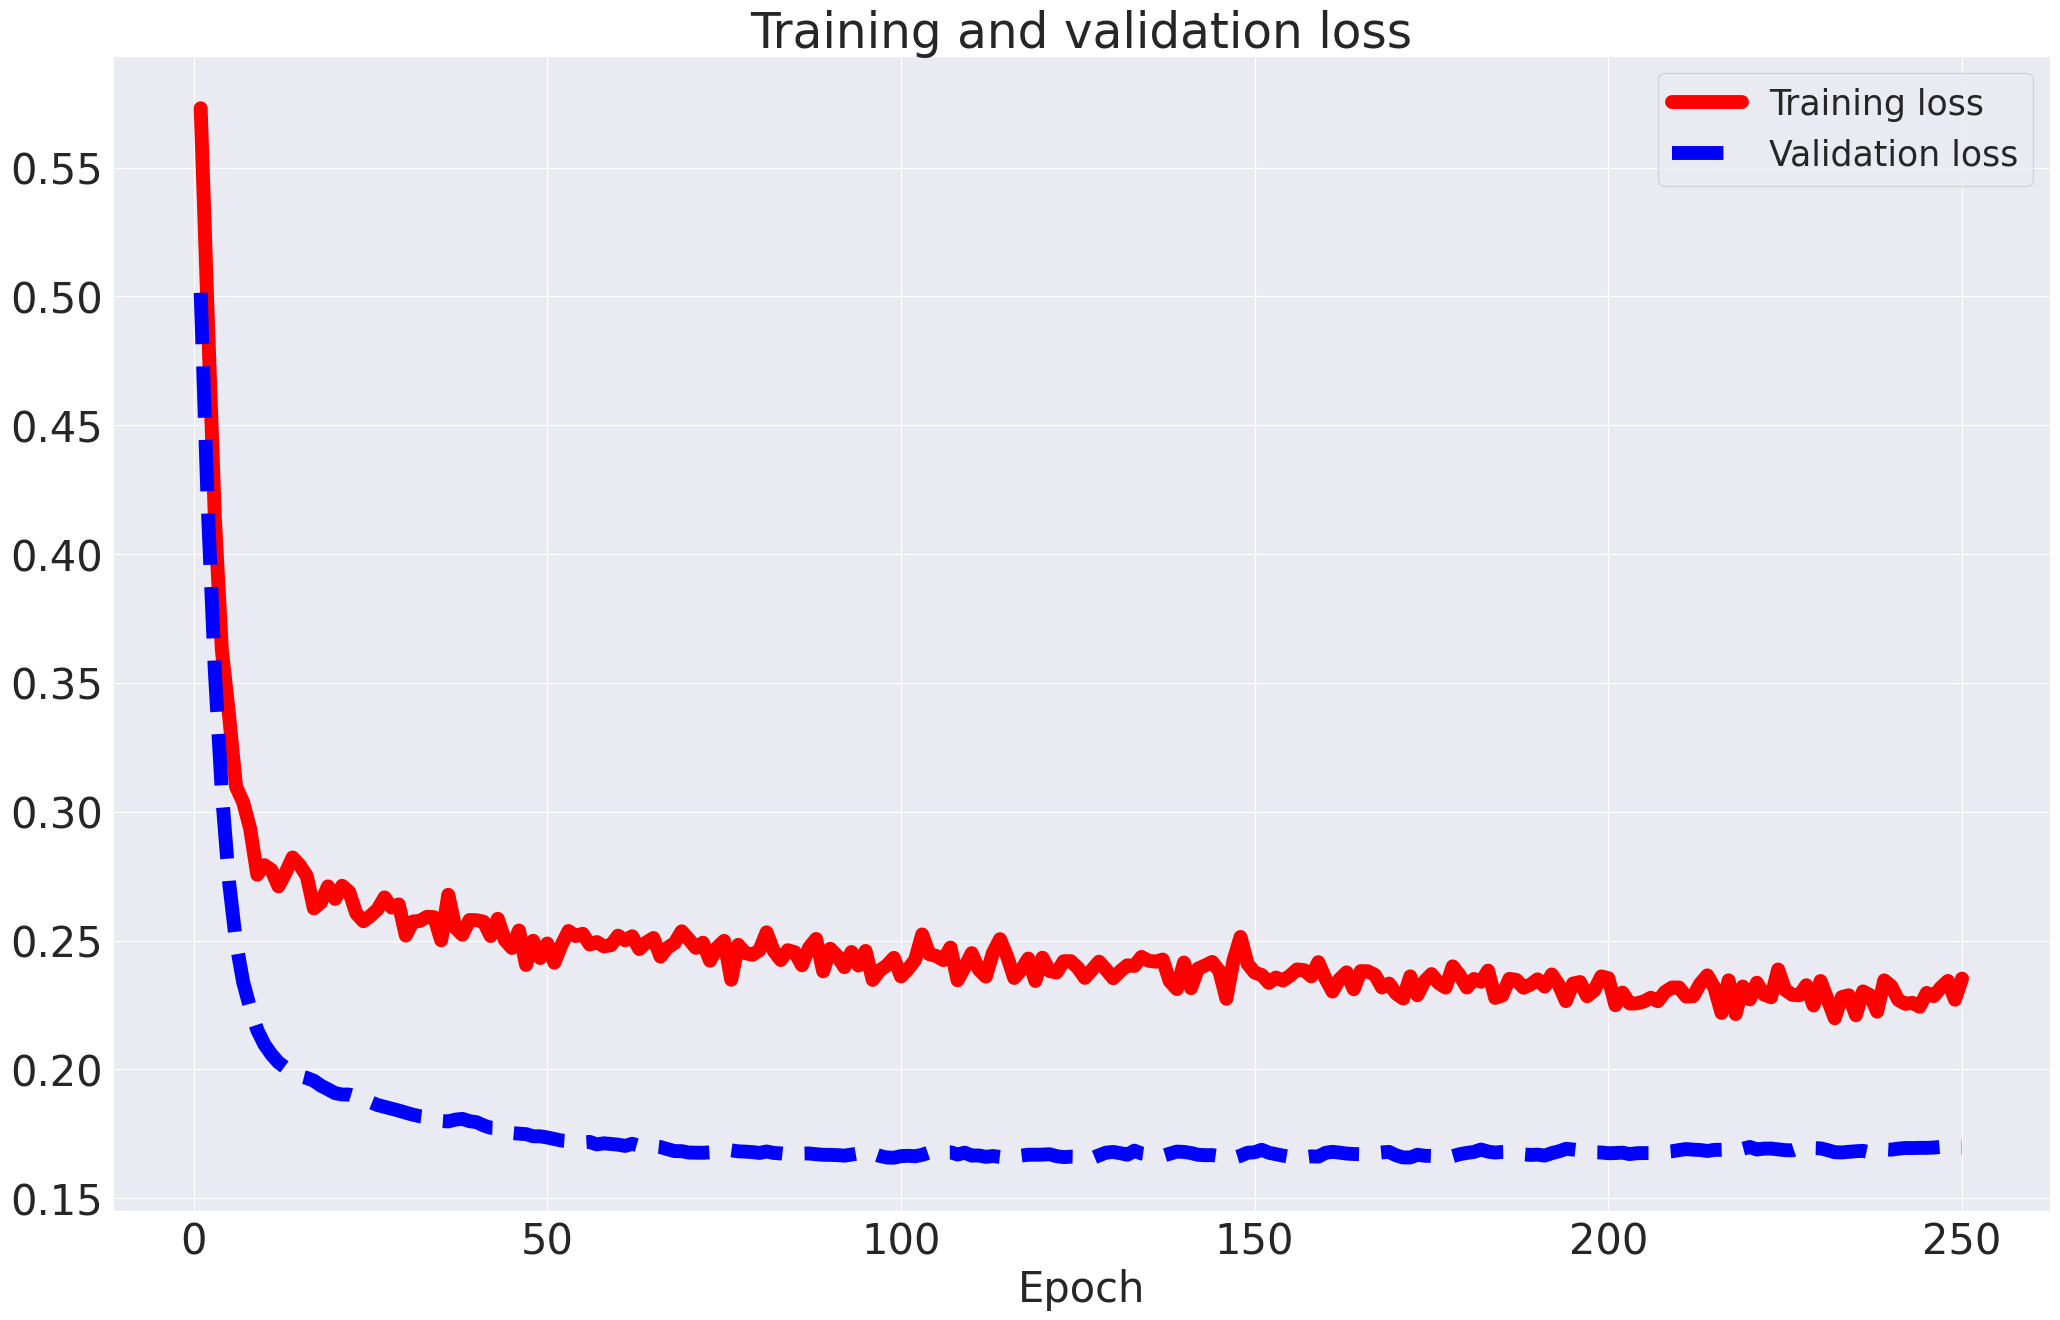

6/6 [==============================] - 0s 2ms/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Accuracy Score :  0.9281437125748503 

Classification Report :

               precision    recall  f1-score   support

           0       0.99      0.93      0.96       166
           1       0.00      0.00      0.00         1

    accuracy                           0.93       167
   macro avg       0.50      0.47      0.48       167
weighted avg       0.99      0.93      0.96       167



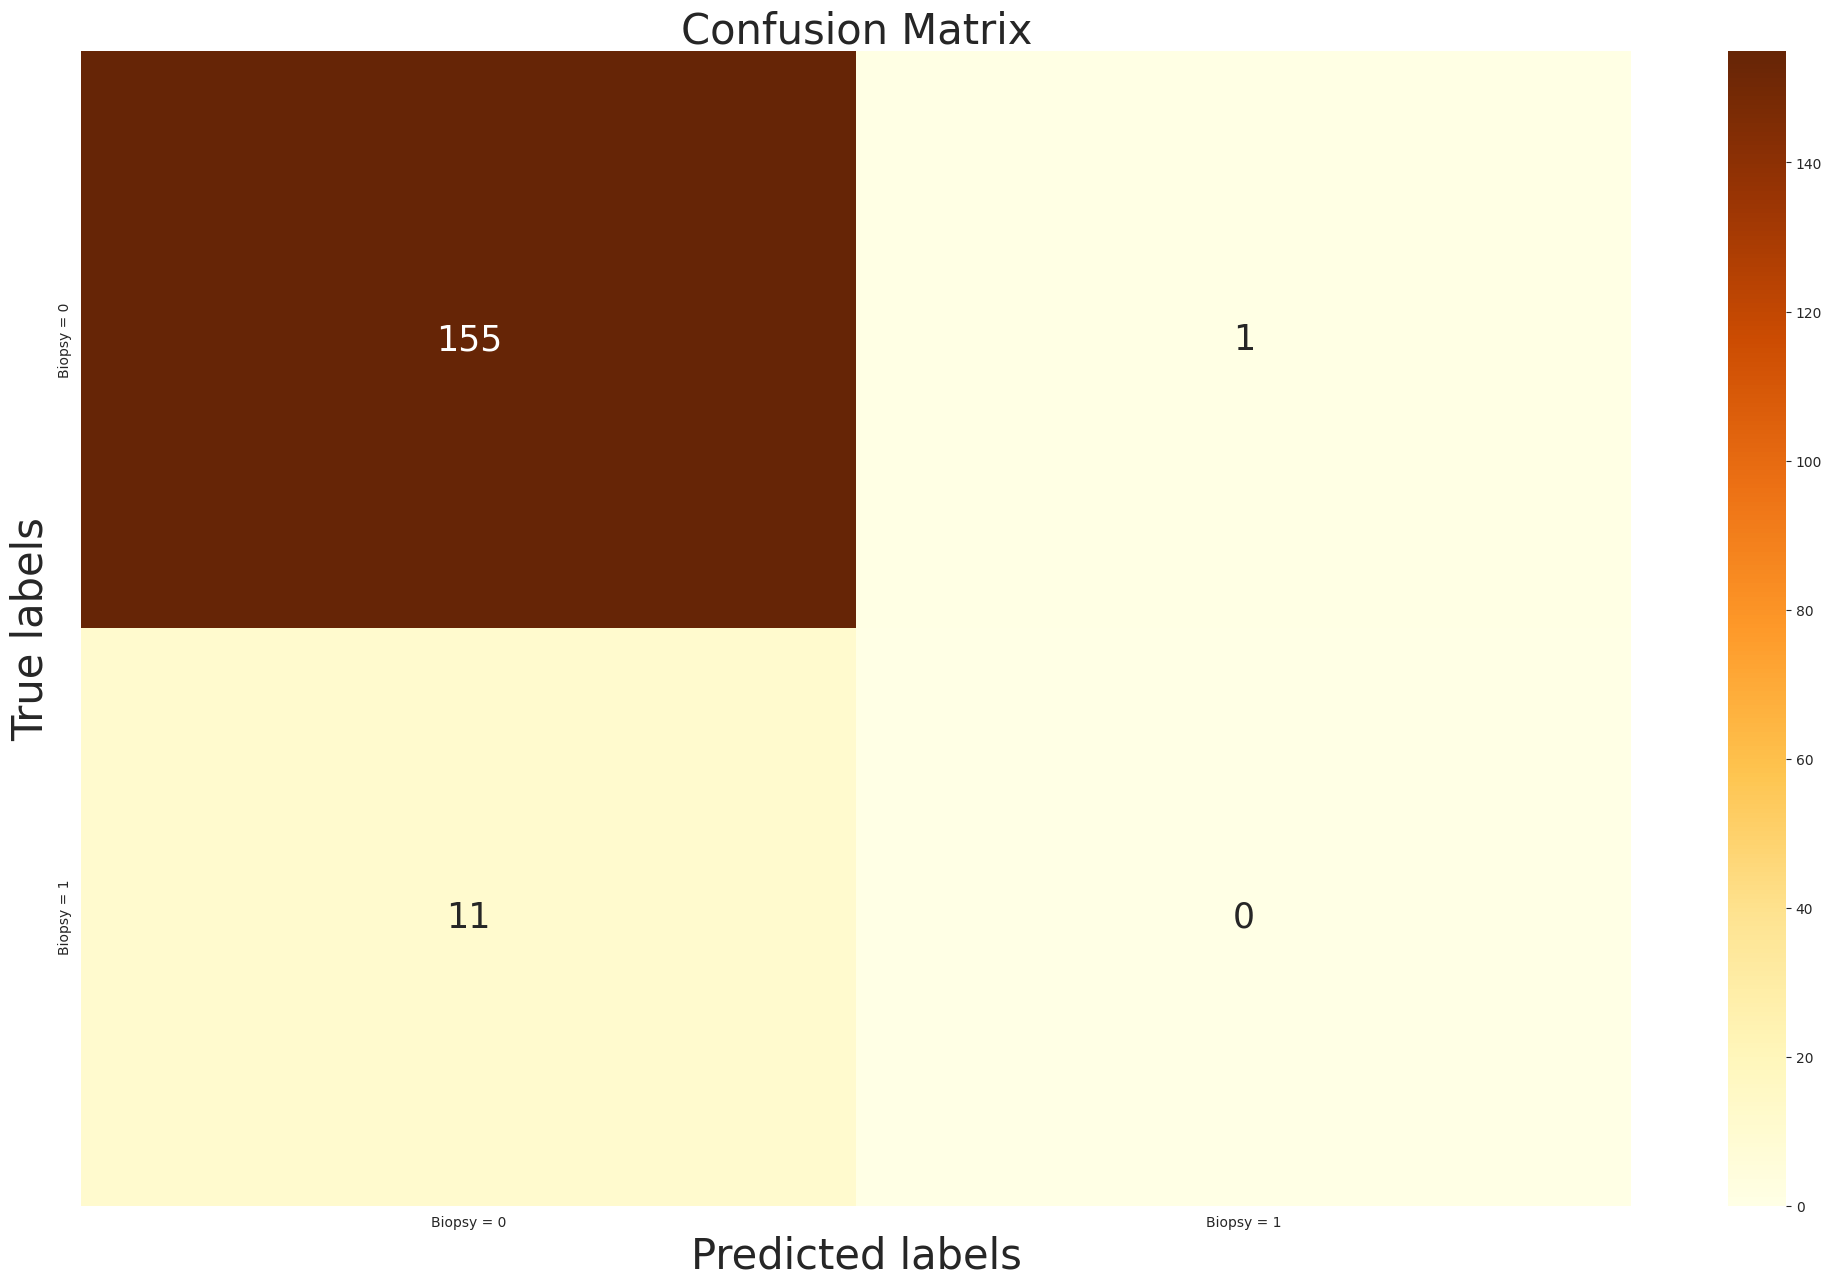

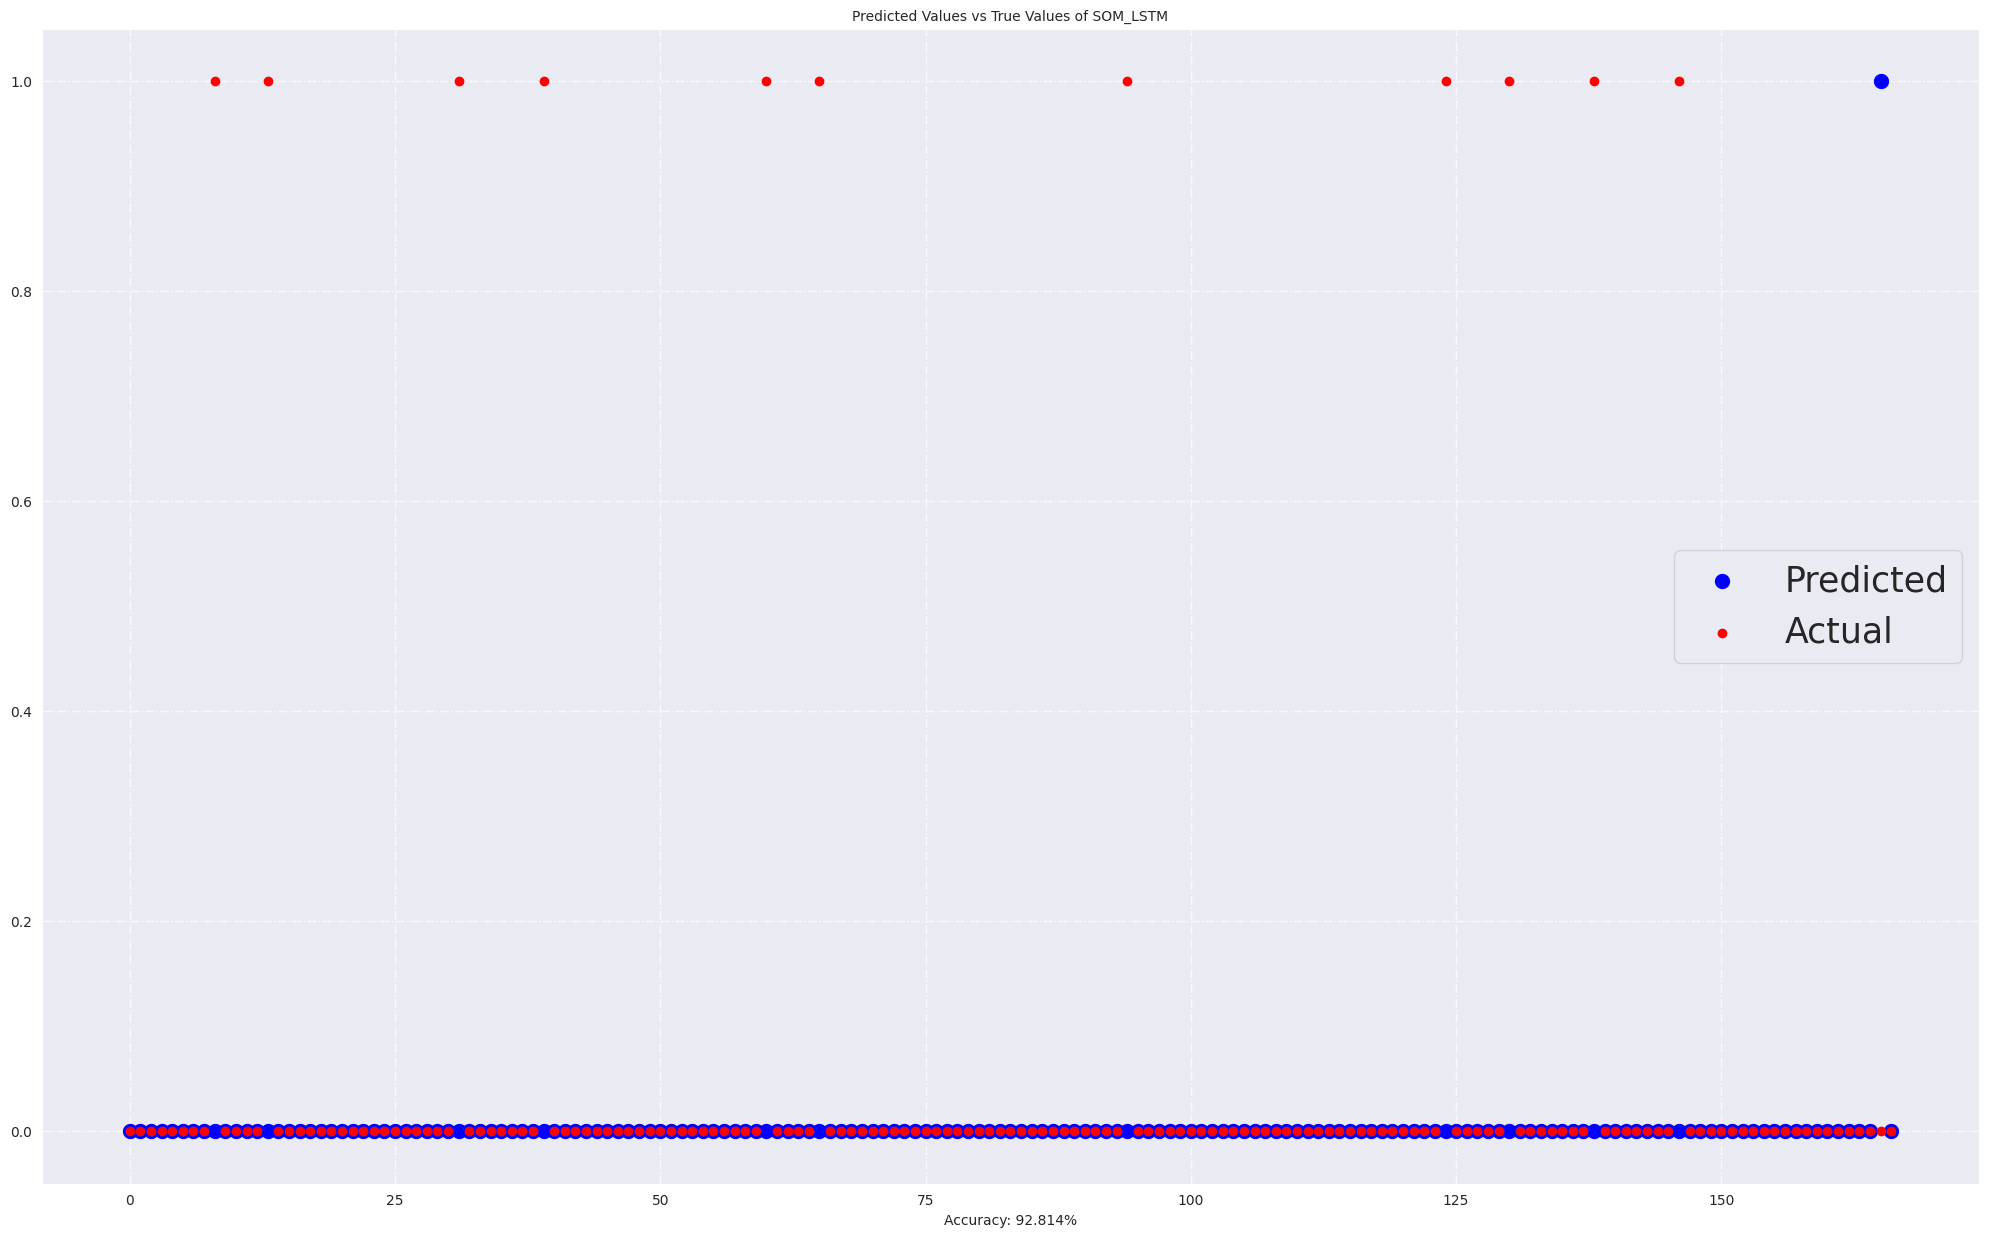

In [17]:
import tensorflow as tf
from sklearn.cluster import KMeans
from minisom import MiniSom
from sklearn.metrics.pairwise import euclidean_distances
X = df.drop('Biopsy', axis=1).apply(pd.to_numeric, errors='coerce').astype('float64')
y = df["Biopsy"]
sc = StandardScaler()
X = sc.fit_transform(X)
# Apply KMeans for SOM initialization
n_centers = 100
kmeans = KMeans(n_clusters=n_centers)
kmeans.fit(X)
centers = kmeans.cluster_centers_
# Train a Self Organizing Map (SOM)
som = MiniSom(x=10, y=10, input_len=X.shape[1], sigma=1.0,learning_rate=0.5)
som.random_weights_init(X)
som.train_random(data=X, num_iteration=100)
# Transform input data into the SOM feature space
X_som = np.array([som.winner(x) for x in X])
X_som = X_som.reshape(X_som.shape[0], -1)
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_som, y,test_size=0.2, random_state=2021, stratify=y)
# Reshape the data for LSTM input
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
# Create an LSTM model
lstm_model = tf.keras.models.Sequential([
 tf.keras.layers.LSTM(units=64, input_shape=(X_train.shape[1],X_train.shape[2])),
 tf.keras.layers.Dropout(0.5),
 tf.keras.layers.Dense(units=1, activation='sigmoid')
])
print(lstm_model.summary()) # Display the model summary
# Compile the LSTM model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
# Train the LSTM model
history = lstm_model.fit(X_train, y_train, batch_size=64,validation_split=0.20, epochs=250, shuffle=True)
# Save the LSTM model
lstm_model.save('cervical_lstm_model_with_som.h5')
#Plots accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#accuracy
fig, ax = plt.subplots(figsize=(25, 15))
plt.plot(epochs, acc, 'r', label='Training accuracy', lw=10)
plt.plot(epochs, val_acc, 'b--', label='Validation accuracy', lw=10)
plt.title('Training and validation accuracy', fontsize=35)
plt.legend(fontsize=25)
ax.set_xlabel("Epoch", fontsize=30)
ax.tick_params(labelsize=30)
plt.show()
#loss
fig, ax = plt.subplots(figsize=(25, 15))
plt.plot(epochs, loss, 'r', label='Training loss', lw=10)
plt.plot(epochs, val_loss, 'b--', label='Validation loss', lw=10)
plt.title('Training and validation loss', fontsize=35)
plt.legend(fontsize=25)
ax.set_xlabel("Epoch", fontsize=30)
ax.tick_params(labelsize=30)
plt.show()
#Sets the threshold for the predictions. In this case, the threshold is 0.5(this value can be modified).
#prediction on test set
y_pred = lstm_model.predict(X_test)
y_pred = [int(p>=0.5) for p in y_pred]
print(y_pred)
#Performance Evaluation - Accuracy and Classification Report
#Accuracy Score
print ('Accuracy Score : ', accuracy_score(y_pred, y_test,normalize=True), '\n')
#precision, recall report
print ('Classification Report :\n\n' ,classification_report(y_pred, y_test))
#Confusion matrix:
conf_mat = confusion_matrix(y_true=y_test, y_pred = y_pred)
class_list = ['Biopsy = 0', 'Biopsy = 1']
fig, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(conf_mat, annot=True, ax = ax, cmap='YlOrBr', fmt='g',
annot_kws={"size": 25})
ax.set_xlabel('Predicted labels', fontsize=30)
ax.set_ylabel('True labels', fontsize=30)
ax.set_title('Confusion Matrix', fontsize=30)
ax.xaxis.set_ticklabels(class_list), ax.yaxis.set_ticklabels(class_list)
def plot_real_pred_val(Y_test, ypred, name):
    plt.figure(figsize=(25,15))
    acc=accuracy_score(Y_test,ypred)

    plt.scatter(range(len(ypred)),ypred,color="blue",lw=5,label="Predicted")
    plt.scatter(range(len(Y_test)), Y_test,color="red",label="Actual")
    plt.title("Predicted Values vs True Values of " + name, fontsize=10)
    plt.xlabel("Accuracy: " + str(round((acc*100),3)) + "%")
    plt.legend(fontsize=25)
    plt.grid(True, alpha=0.75, lw=1, ls='-.')
    plt.show()
plot_real_pred_val(y_test, y_pred, 'SOM_LSTM')

# Cervical Cancer Using Deep Belief Networks (DBNs) Model


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 500)               17000     
                                                                 
 dropout_4 (Dropout)         (None, 500)               0         
                                                                 
 dense_6 (Dense)             (None, 200)               100200    
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 117401 (458.60 KB)
Trainable params: 117401 (458.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/2

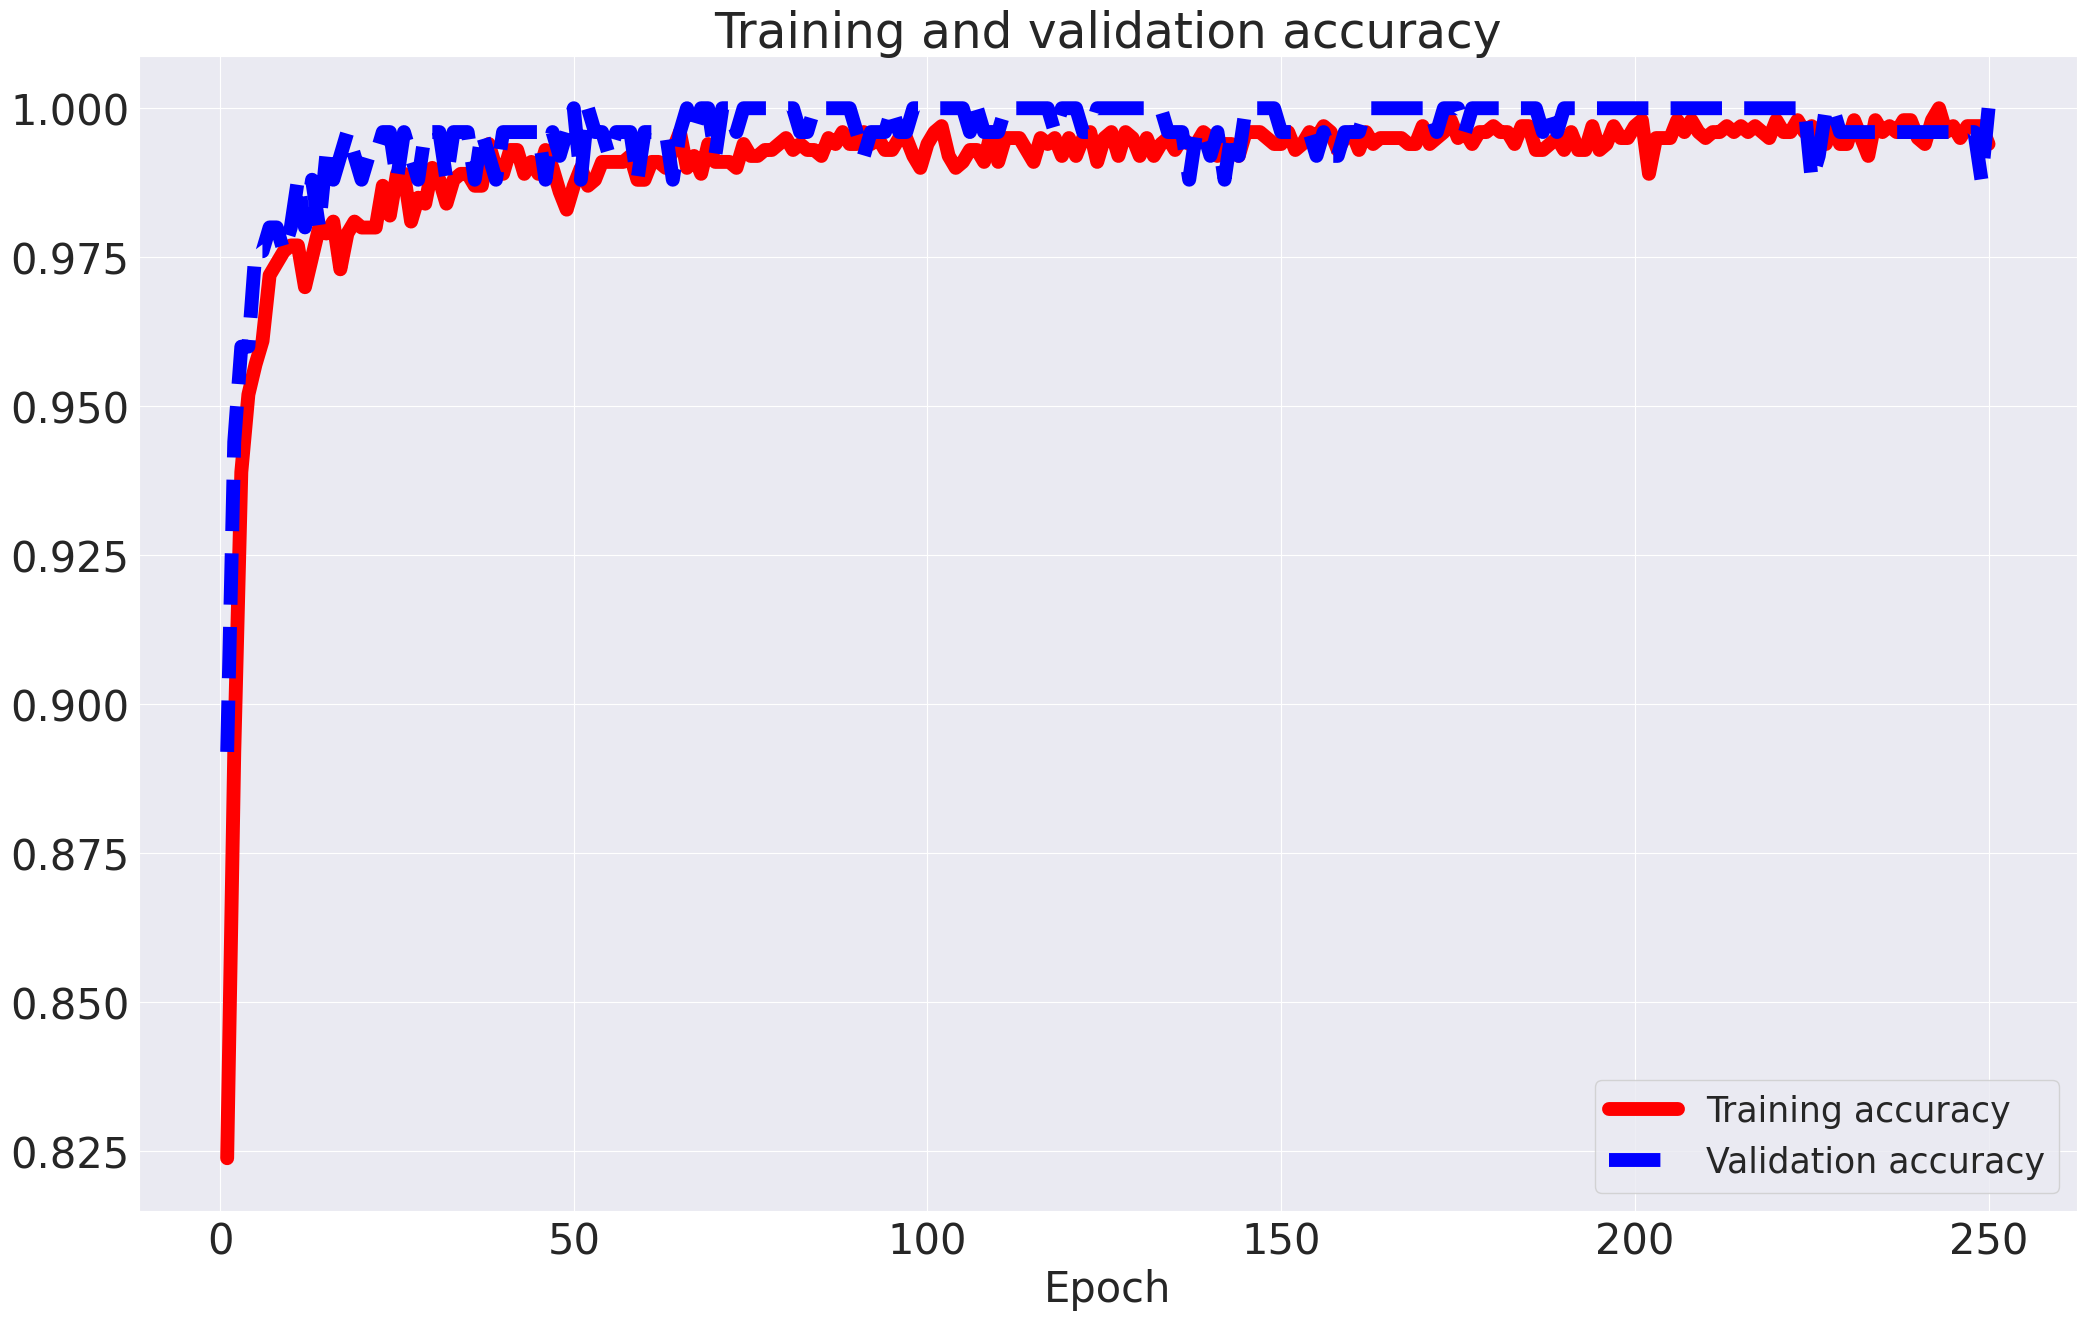

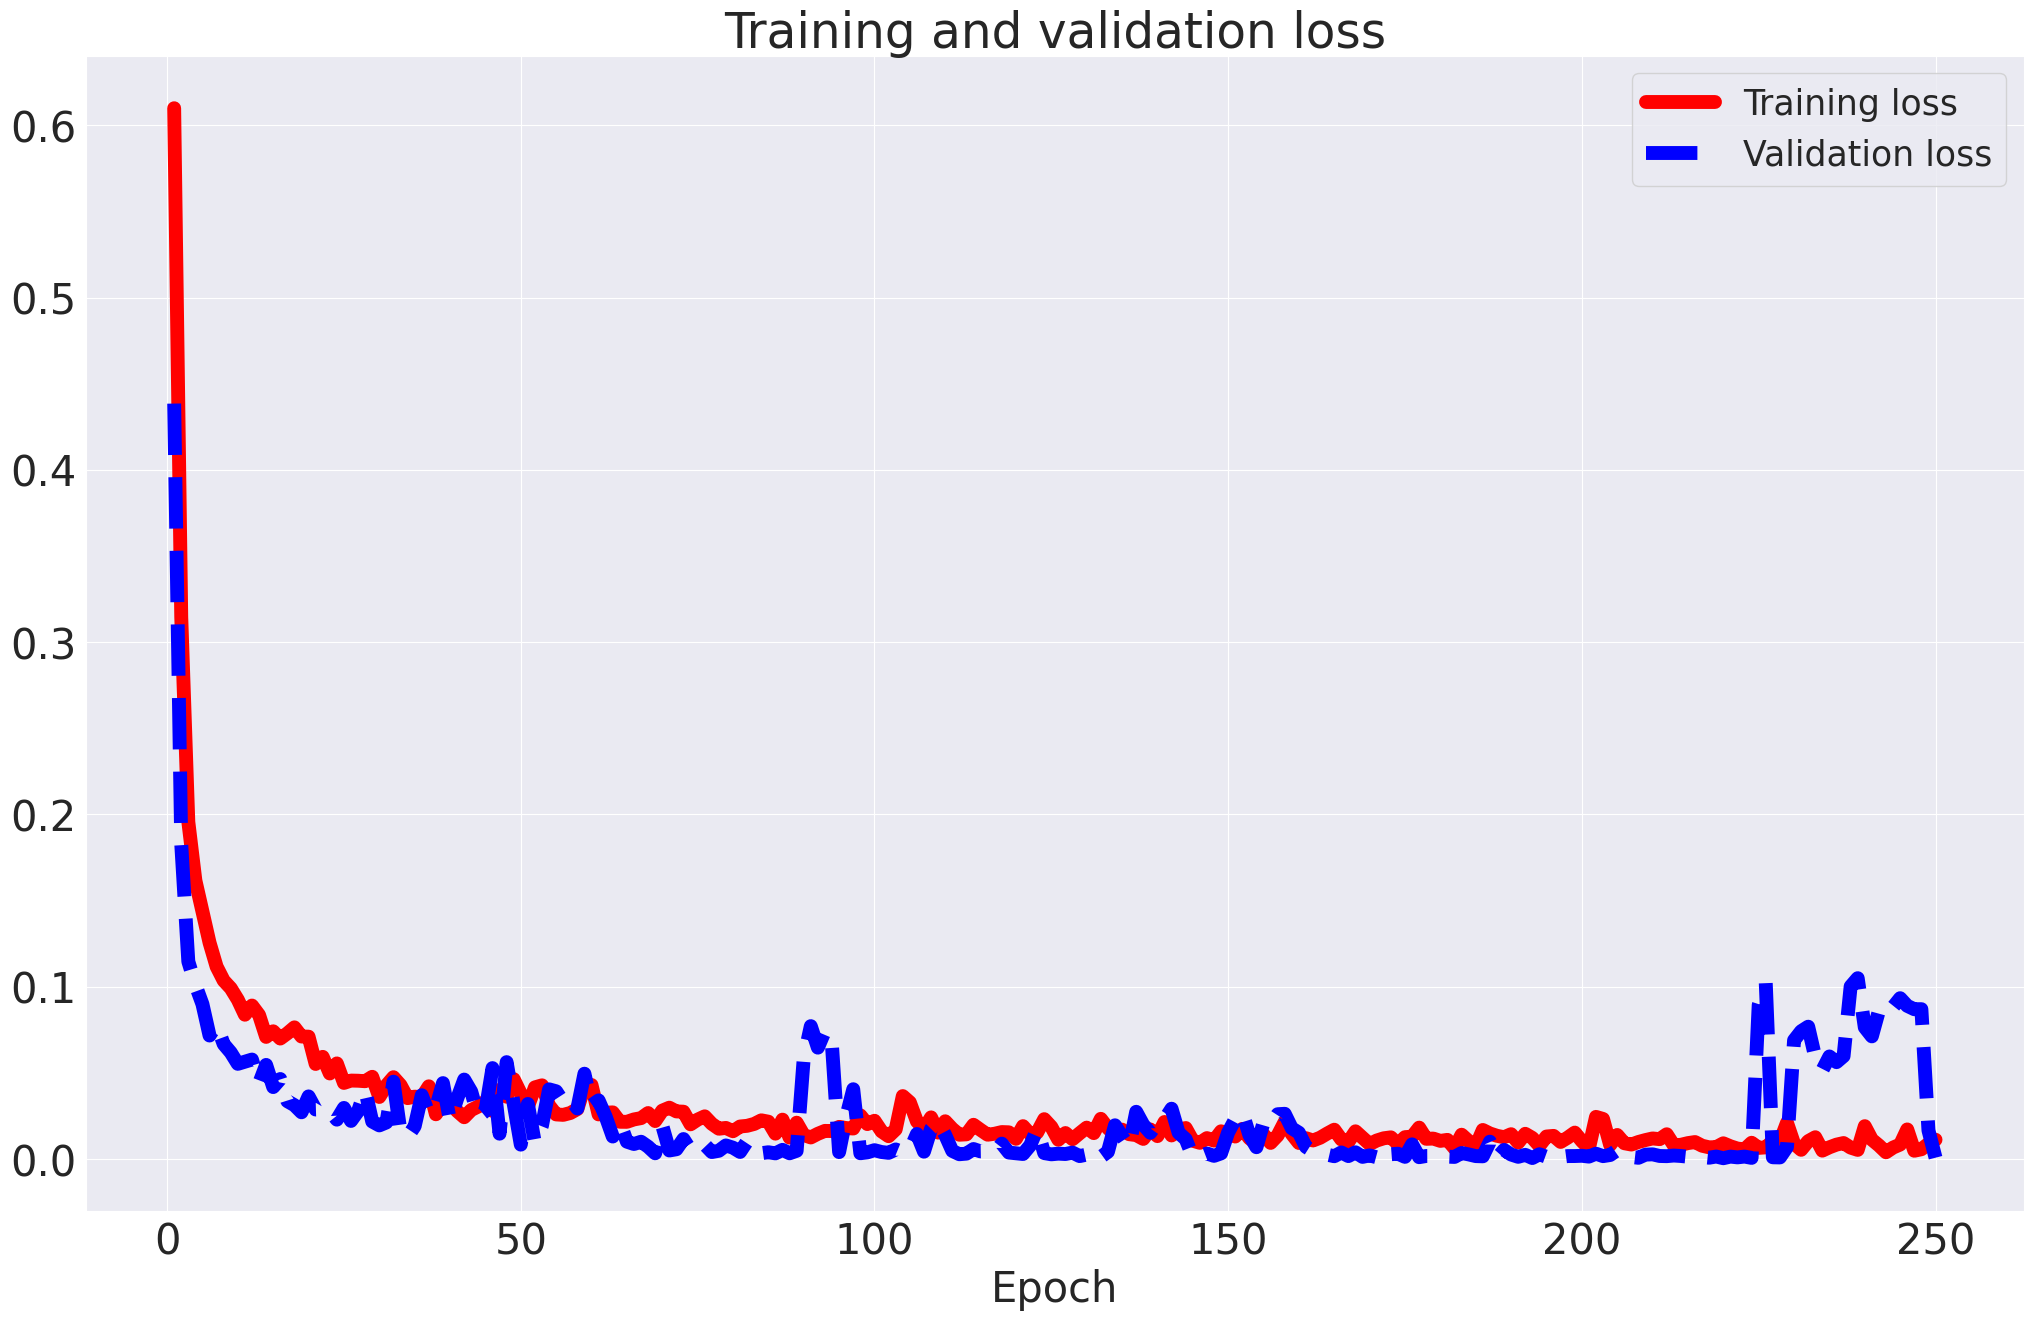

10/10 [==============================] - 0s 2ms/step
[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Accurac

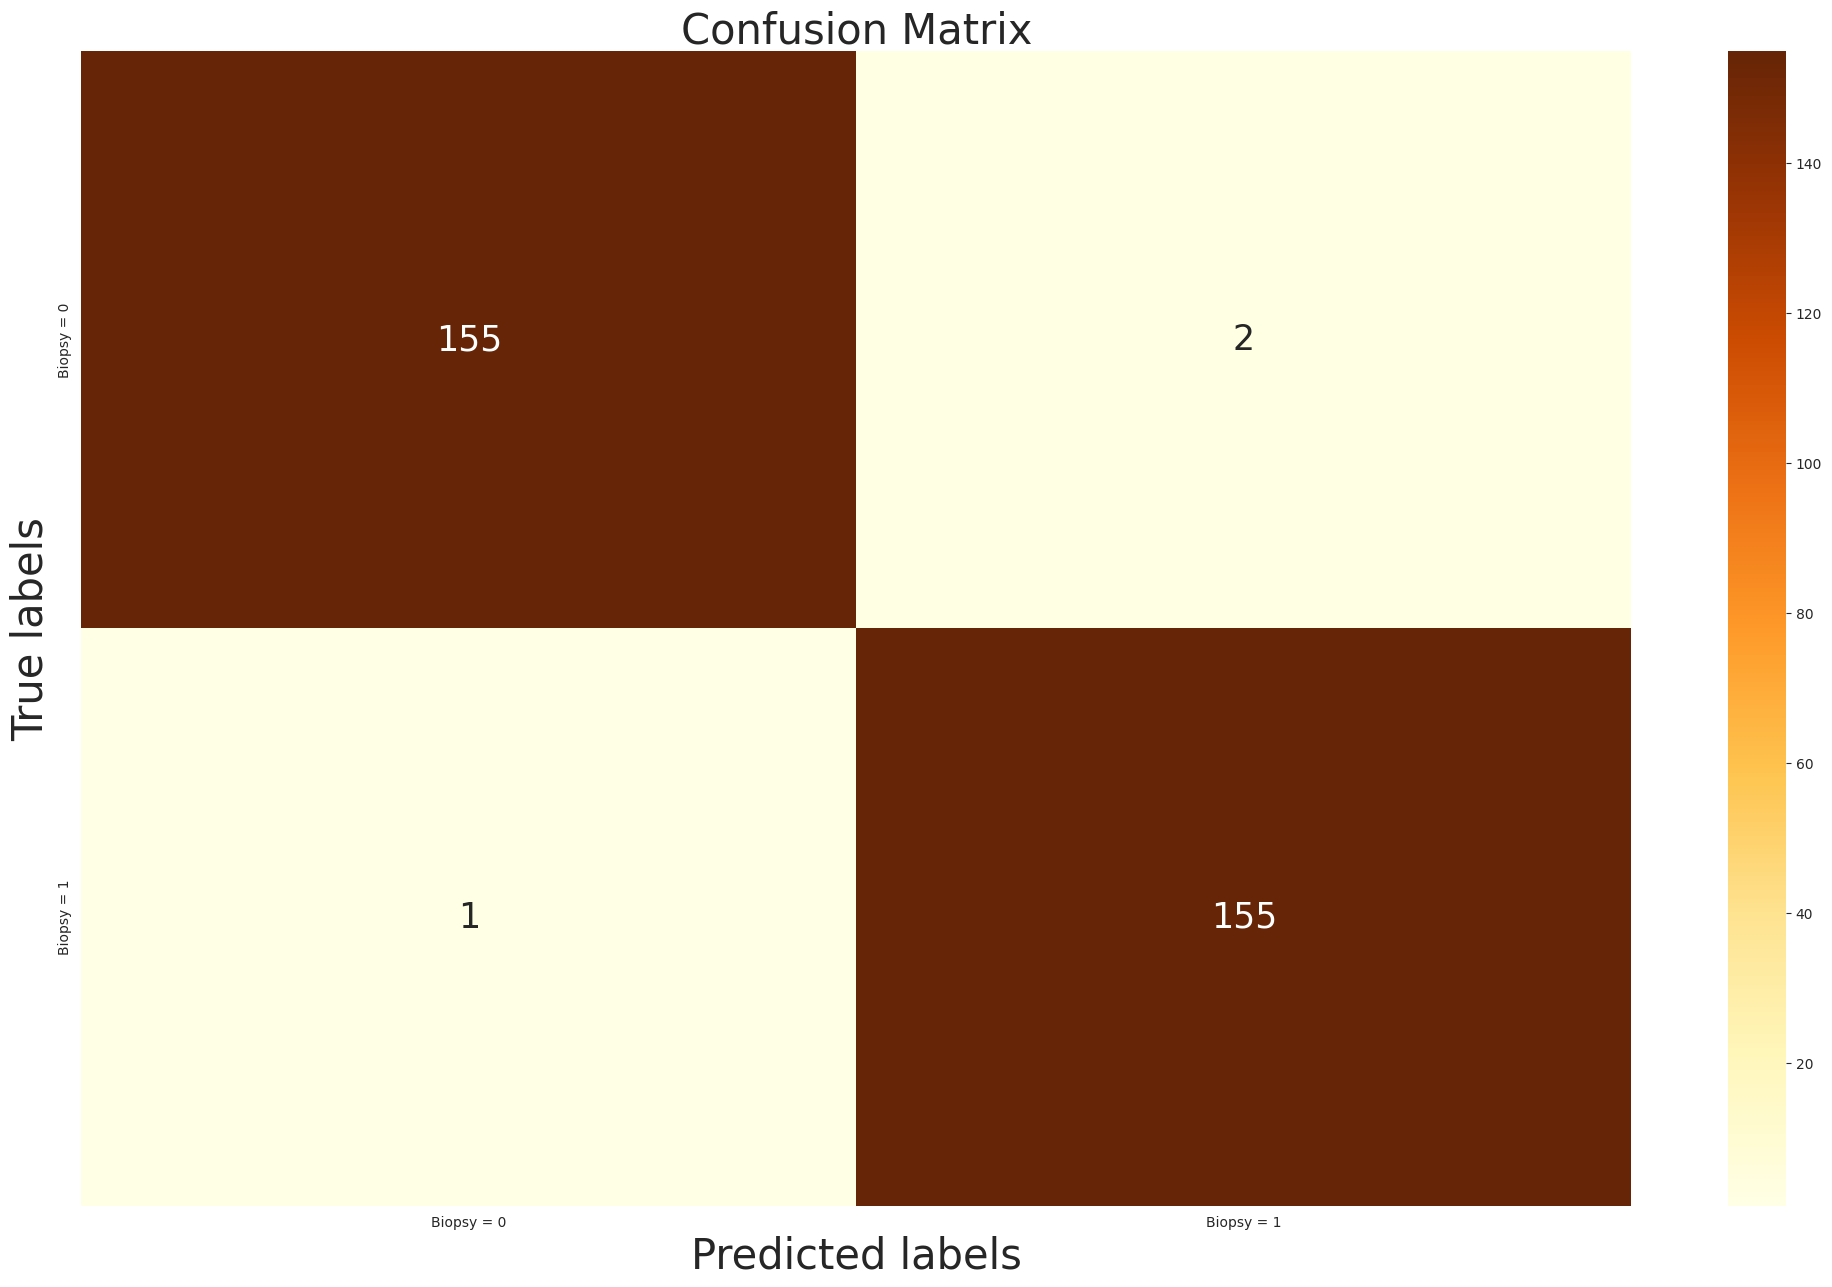

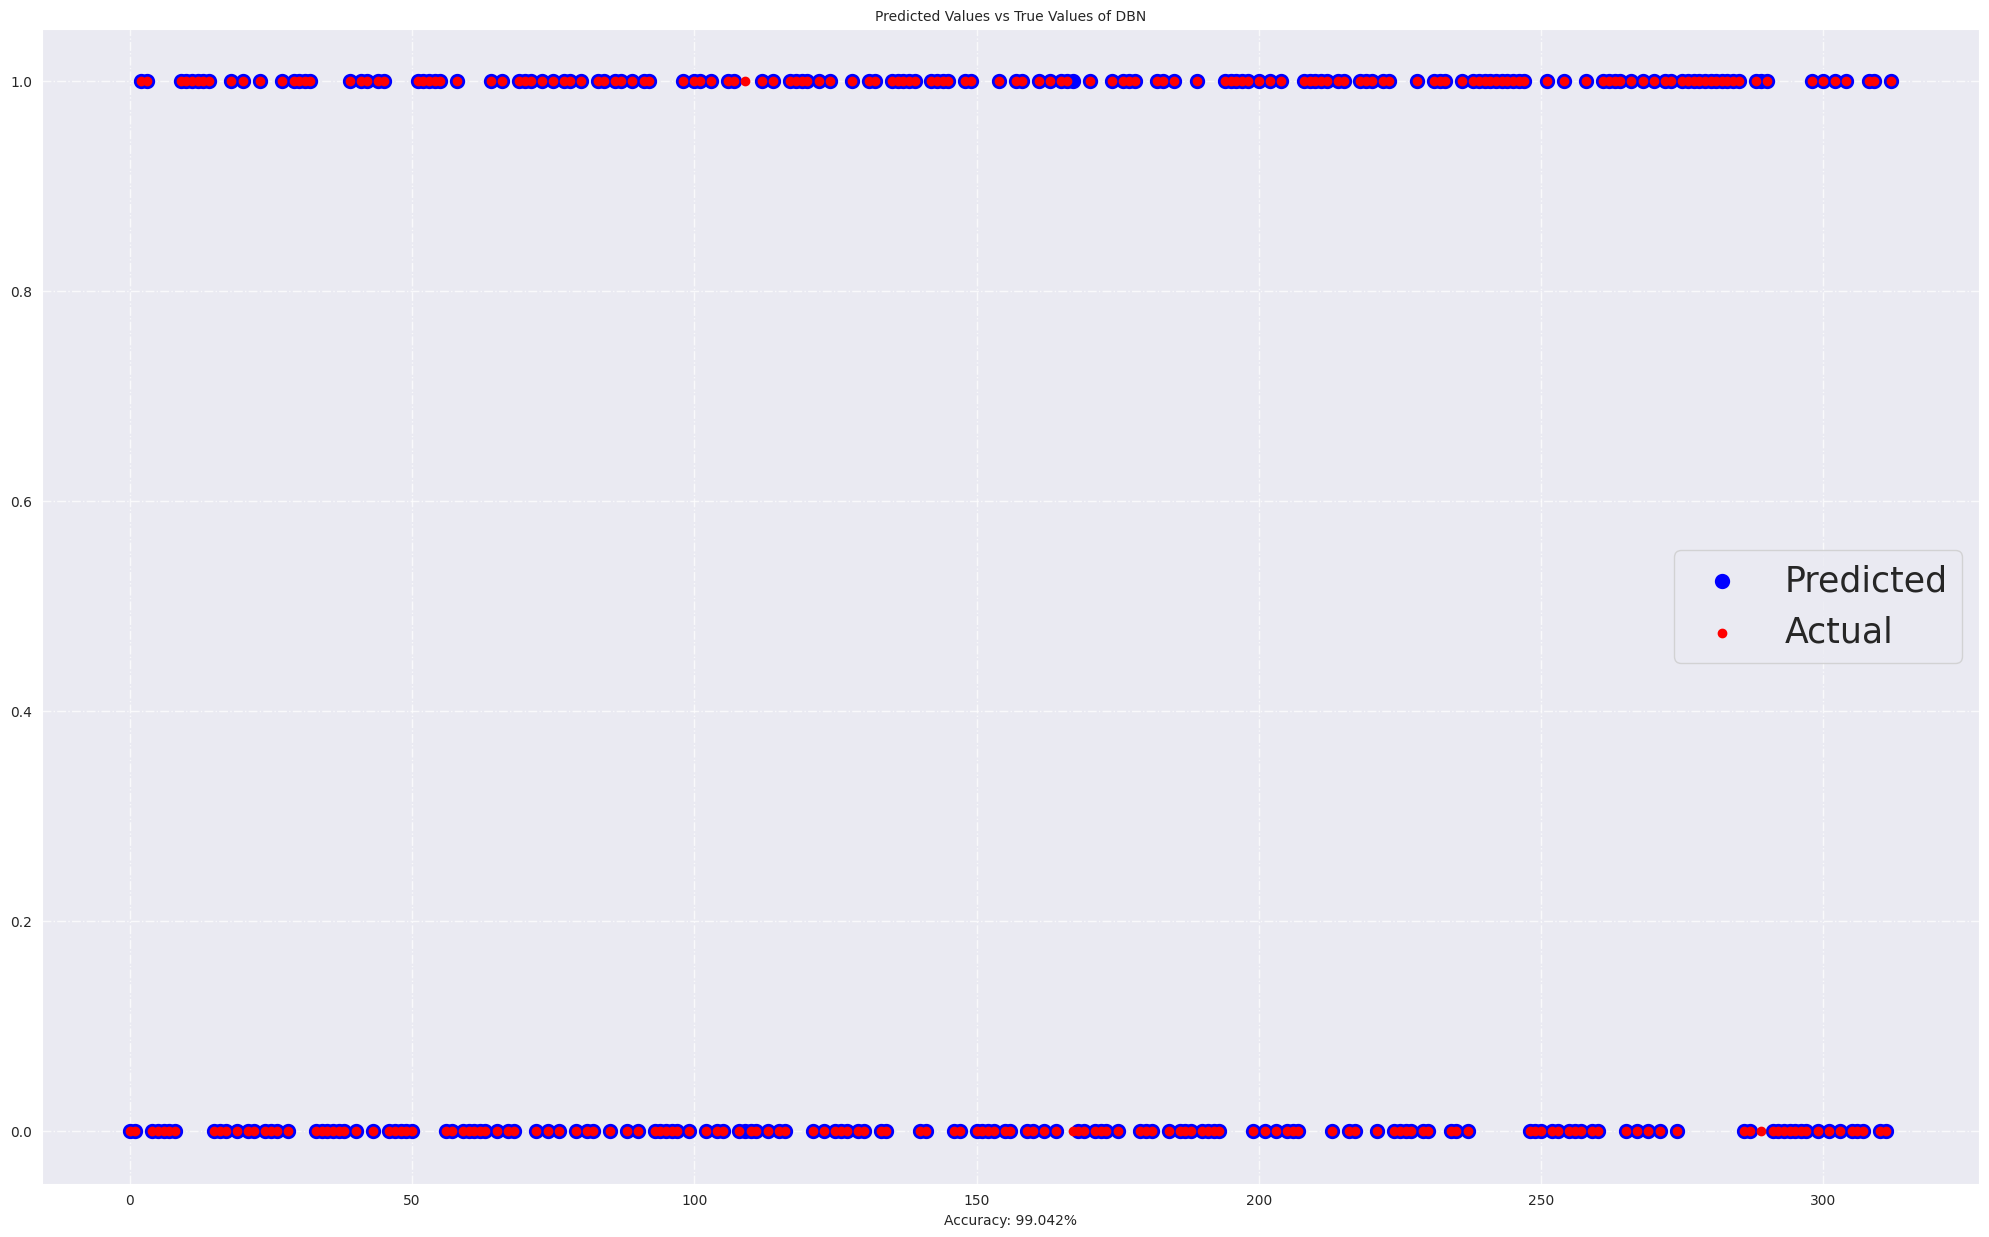

In [18]:
X = df.drop('Biopsy', axis=1).apply(pd.to_numeric,
errors='coerce').astype('float64')
y = df["Biopsy"]
sm = SMOTE(random_state=42)
X,y = sm.fit_resample(X, y.ravel())
# Splits the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.2, random_state=2021, stratify=y)
# Standard scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# Create a Deep Belief Network (DBN)
dbn_model = tf.keras.models.Sequential([
 tf.keras.layers.Dense(units=500, input_dim=33,kernel_initializer='uniform', activation='relu'),
 tf.keras.layers.Dropout(0.5),
 tf.keras.layers.Dense(units=200, kernel_initializer='uniform',activation='relu'),
 tf.keras.layers.Dropout(0.5),
 tf.keras.layers.Dense(units=1, kernel_initializer='uniform',activation='sigmoid')
])
print(dbn_model.summary()) # Display the model summary
# Compile the DBN model
dbn_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
# Train the DBN model
history = dbn_model.fit(X_train, y_train, batch_size=64,validation_split=0.20, epochs=250, shuffle=True)
# Save the DBN model
dbn_model.save('cervical_dbn_model.h5')
# Save history into npy file
np.save('cervical_dbn_history.npy', history.history)
print(history.history.keys())
# Plots accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
# Accuracy
fig, ax = plt.subplots(figsize=(25, 15))
plt.plot(epochs, acc, 'r', label='Training accuracy', lw=10)
plt.plot(epochs, val_acc, 'b--', label='Validation accuracy', lw=10)
plt.title('Training and validation accuracy', fontsize=35)
plt.legend(fontsize=25)
ax.set_xlabel("Epoch", fontsize=30)
ax.tick_params(labelsize=30)
plt.show()
# Loss
fig, ax = plt.subplots(figsize=(25, 15))
plt.plot(epochs, loss, 'r', label='Training loss', lw=10)
plt.plot(epochs, val_loss, 'b--', label='Validation loss', lw=10)
plt.title('Training and validation loss', fontsize=35)
plt.legend(fontsize=25)
ax.set_xlabel("Epoch", fontsize=30)
ax.tick_params(labelsize=30)
plt.show()
# Sets the threshold for the predictions. In this case, the threshold is 0.5 (this value can be modified).
# Prediction on test set
y_pred = dbn_model.predict(X_test)
y_pred = [int(p>=0.5) for p in y_pred]
print(y_pred)
# Performance Evaluation - Accuracy and Classification Report
# Accuracy Score
print('Accuracy Score : ', accuracy_score(y_pred, y_test,normalize=True), '\n')
# Precision, recall report
print('Classification Report :\n\n', classification_report(y_pred,y_test))
# Confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
class_list = ['Biopsy = 0', 'Biopsy = 1']
fig, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(conf_mat, annot=True, ax=ax, cmap='YlOrBr',fmt='g', annot_kws={"size": 25})
ax.set_xlabel('Predicted labels', fontsize=30)
ax.set_ylabel('True labels', fontsize=30)
ax.set_title('Confusion Matrix', fontsize=30)
ax.xaxis.set_ticklabels(class_list),
ax.yaxis.set_ticklabels(class_list)

plot_real_pred_val(y_test, y_pred, 'DBN')


# Cervical Cancer Using Autoencoders Model

Epoch 1/100
16/16 [==============================] - 2s 16ms/step - loss: 0.8831 - val_loss: 0.6825
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.6044 - val_loss: 0.4937
Epoch 3/100
16/16 [==============================] - 0s 5ms/step - loss: 0.4183 - val_loss: 0.3437
Epoch 4/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2771 - val_loss: 0.2506
Epoch 5/100
16/16 [==============================] - 0s 5ms/step - loss: 0.2011 - val_loss: 0.1936
Epoch 6/100
16/16 [==============================] - 0s 5ms/step - loss: 0.1564 - val_loss: 0.1591
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.1296 - val_loss: 0.1377
Epoch 8/100
16/16 [==============================] - 0s 5ms/step - loss: 0.1094 - val_loss: 0.1209
Epoch 9/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0947 - val_loss: 0.1090
Epoch 10/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0820 - val_loss: 0.0962
Epoch 11

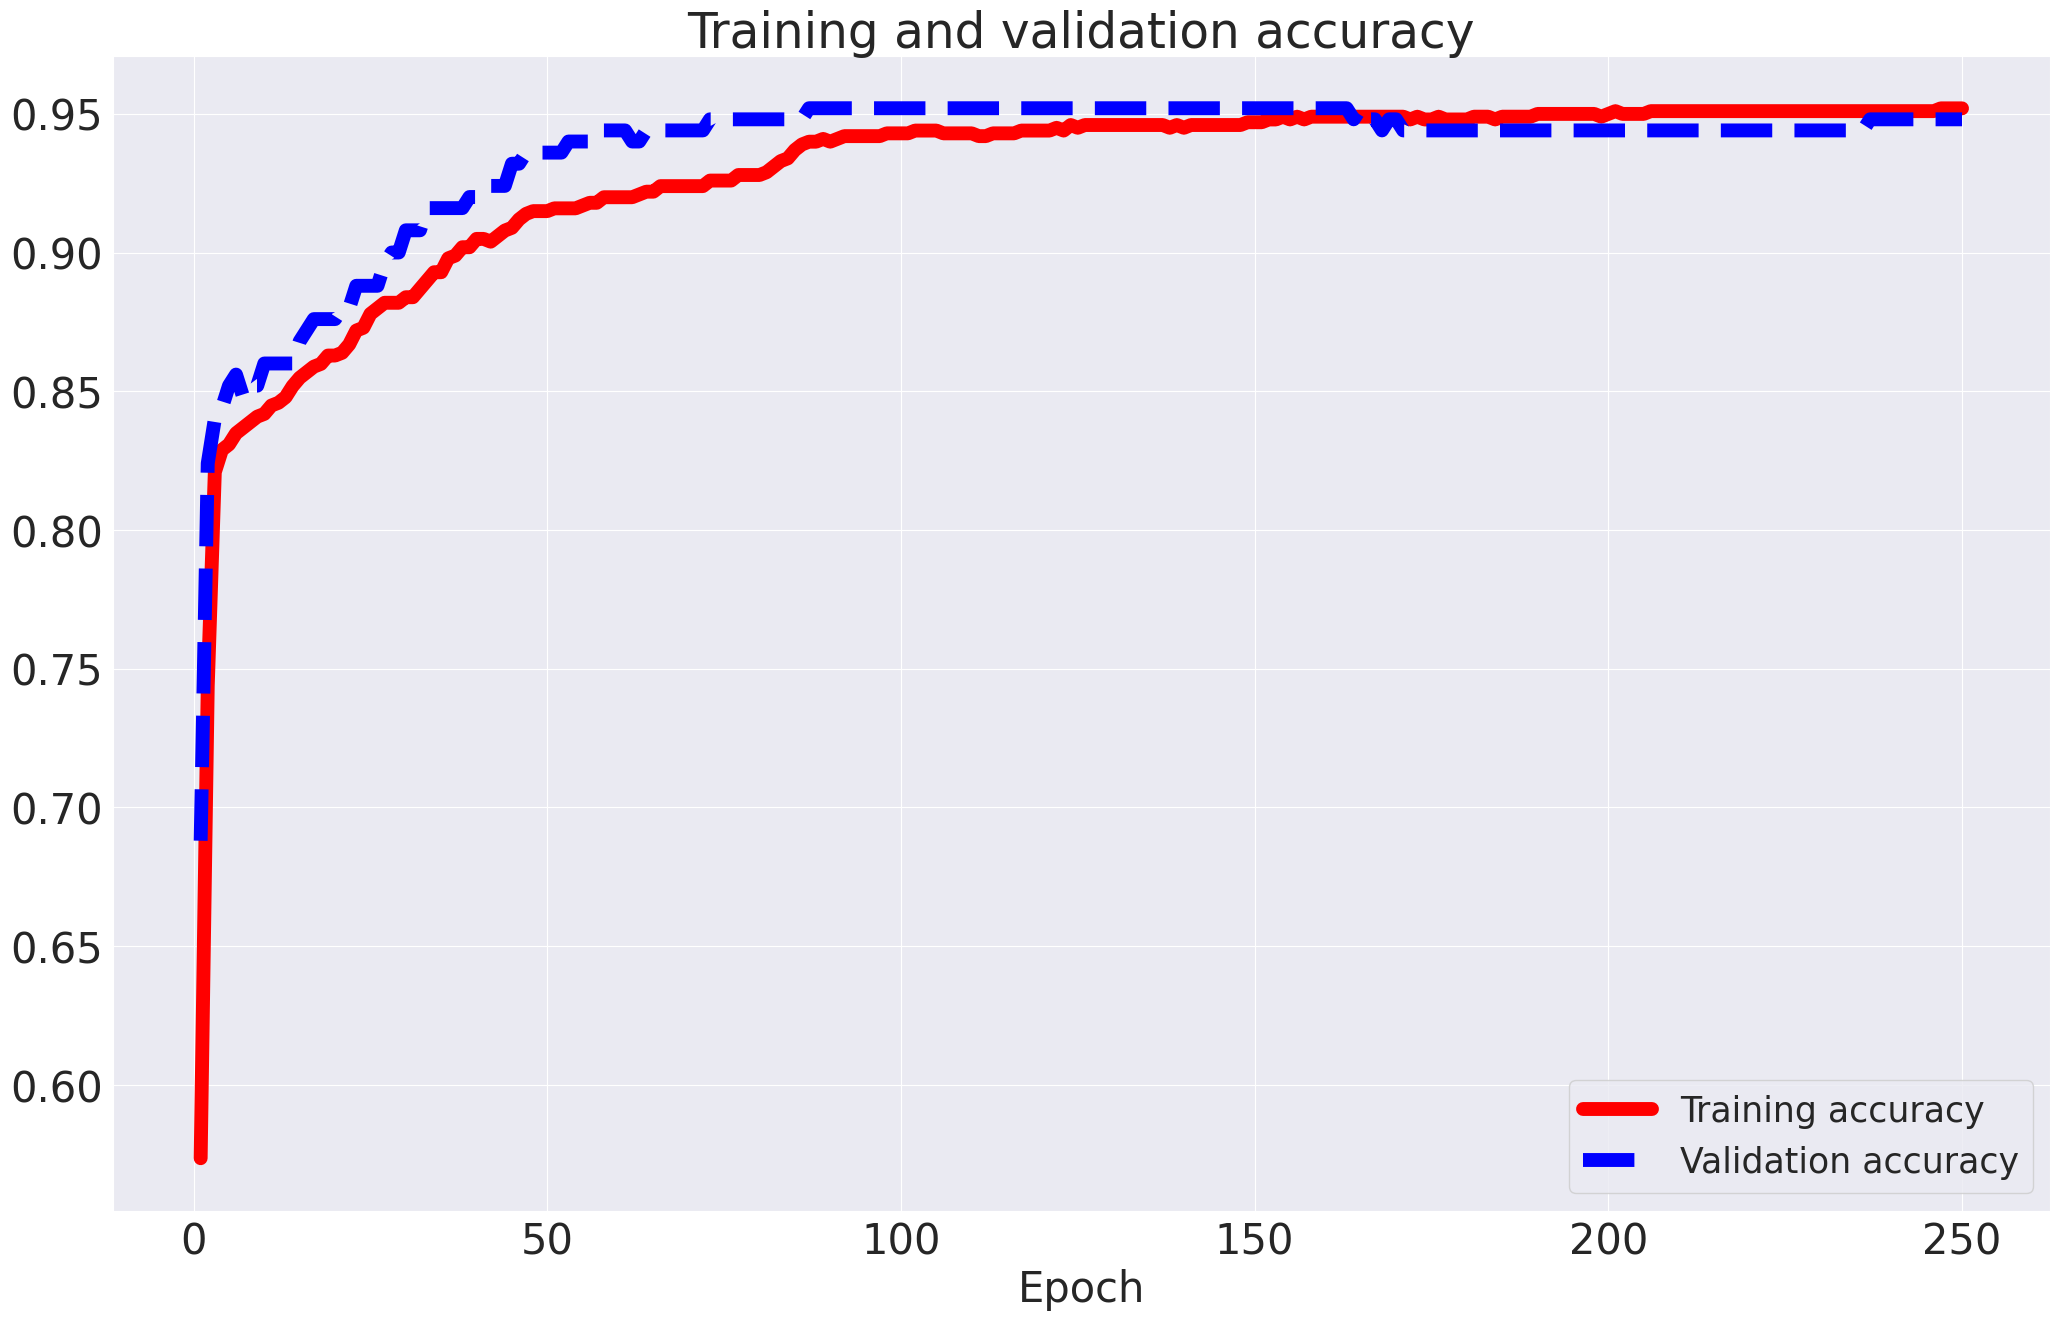

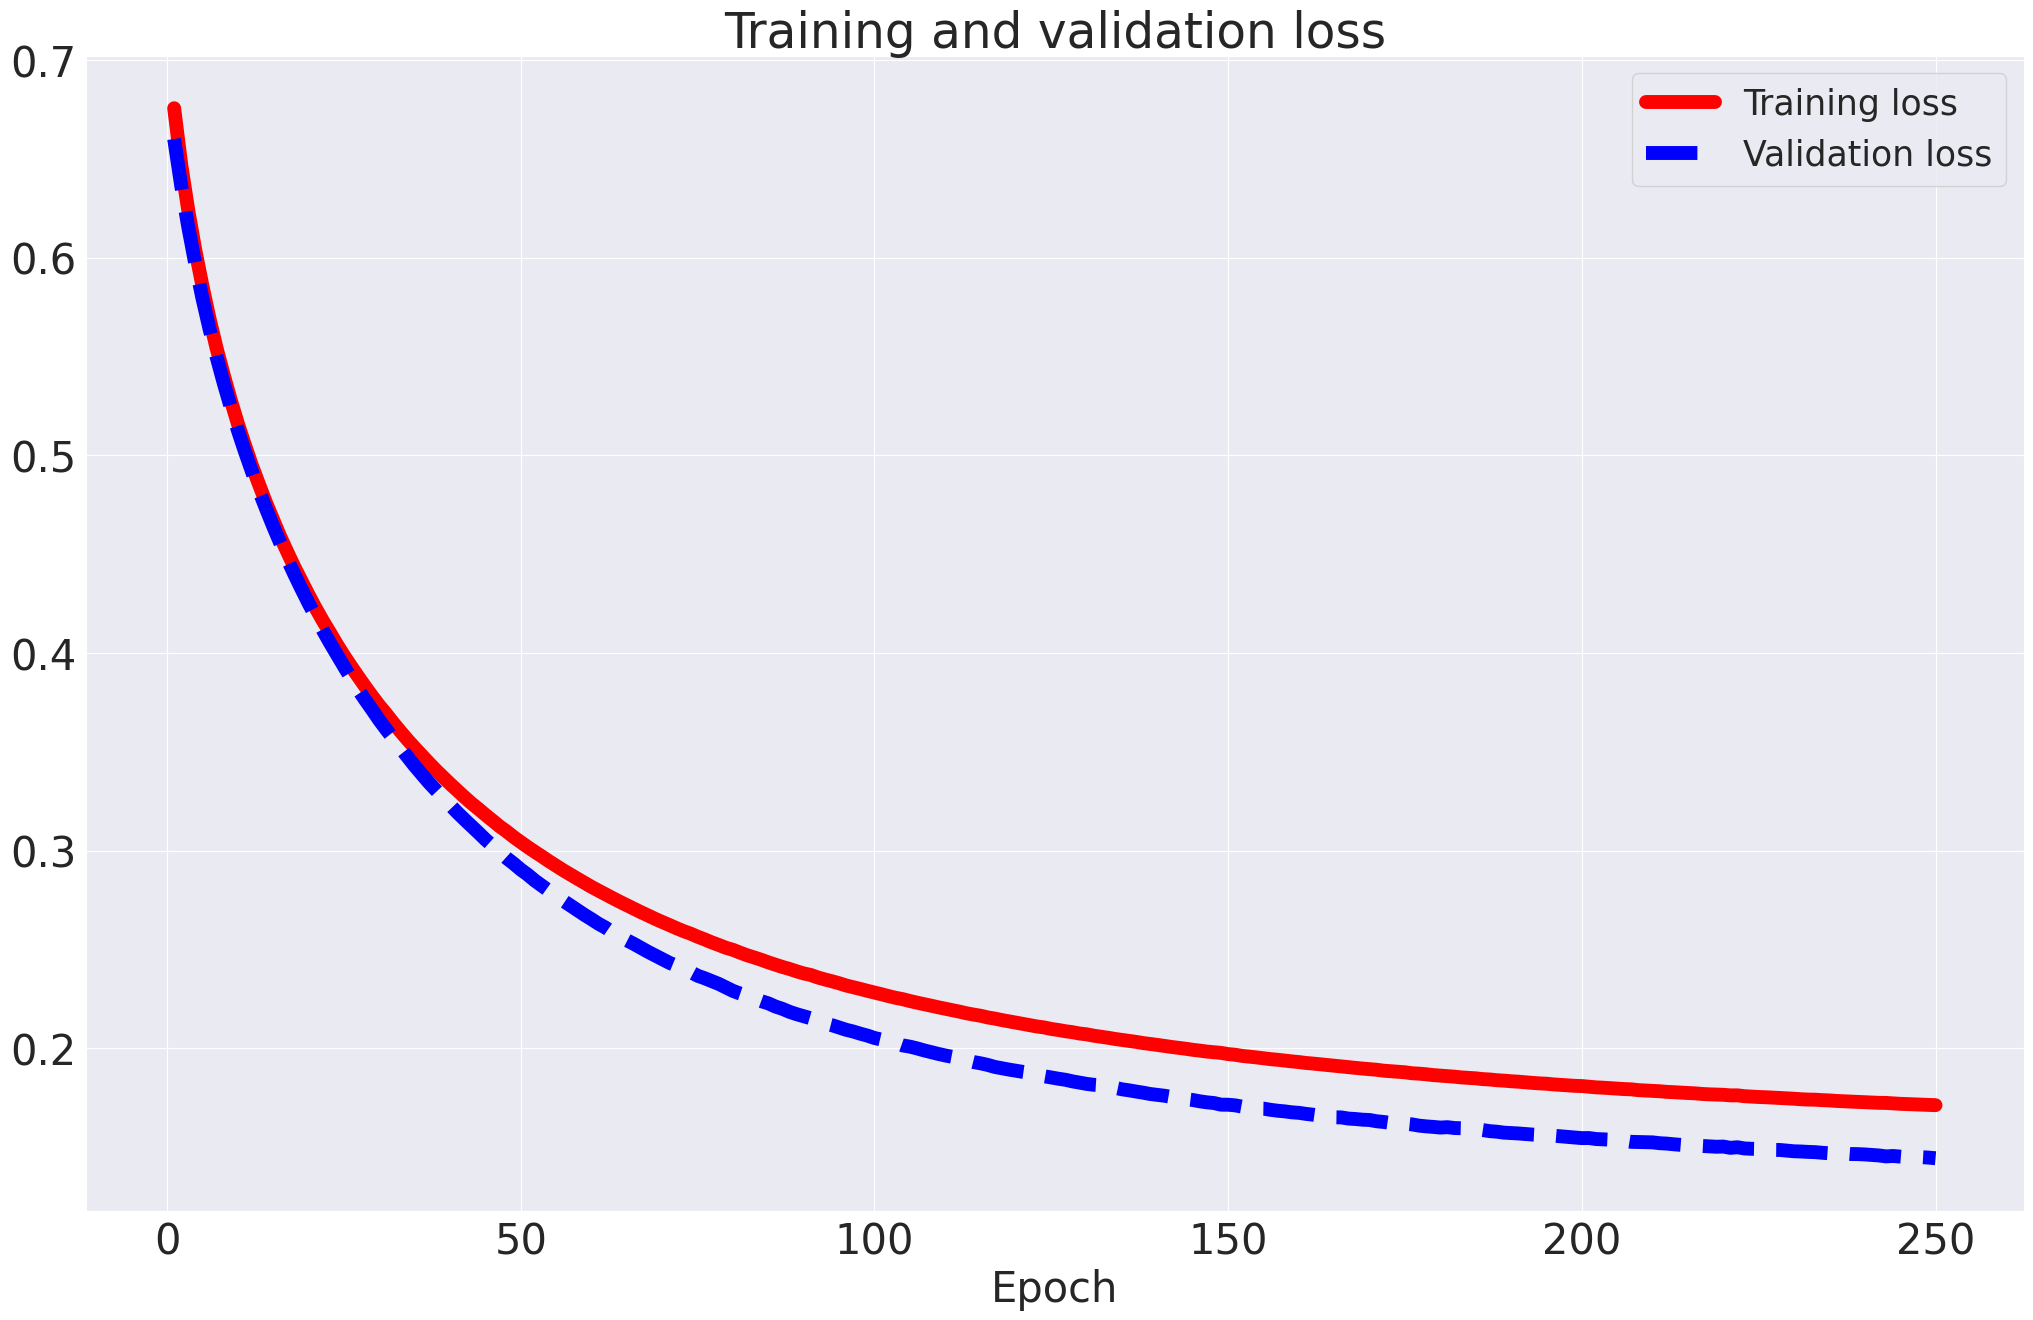

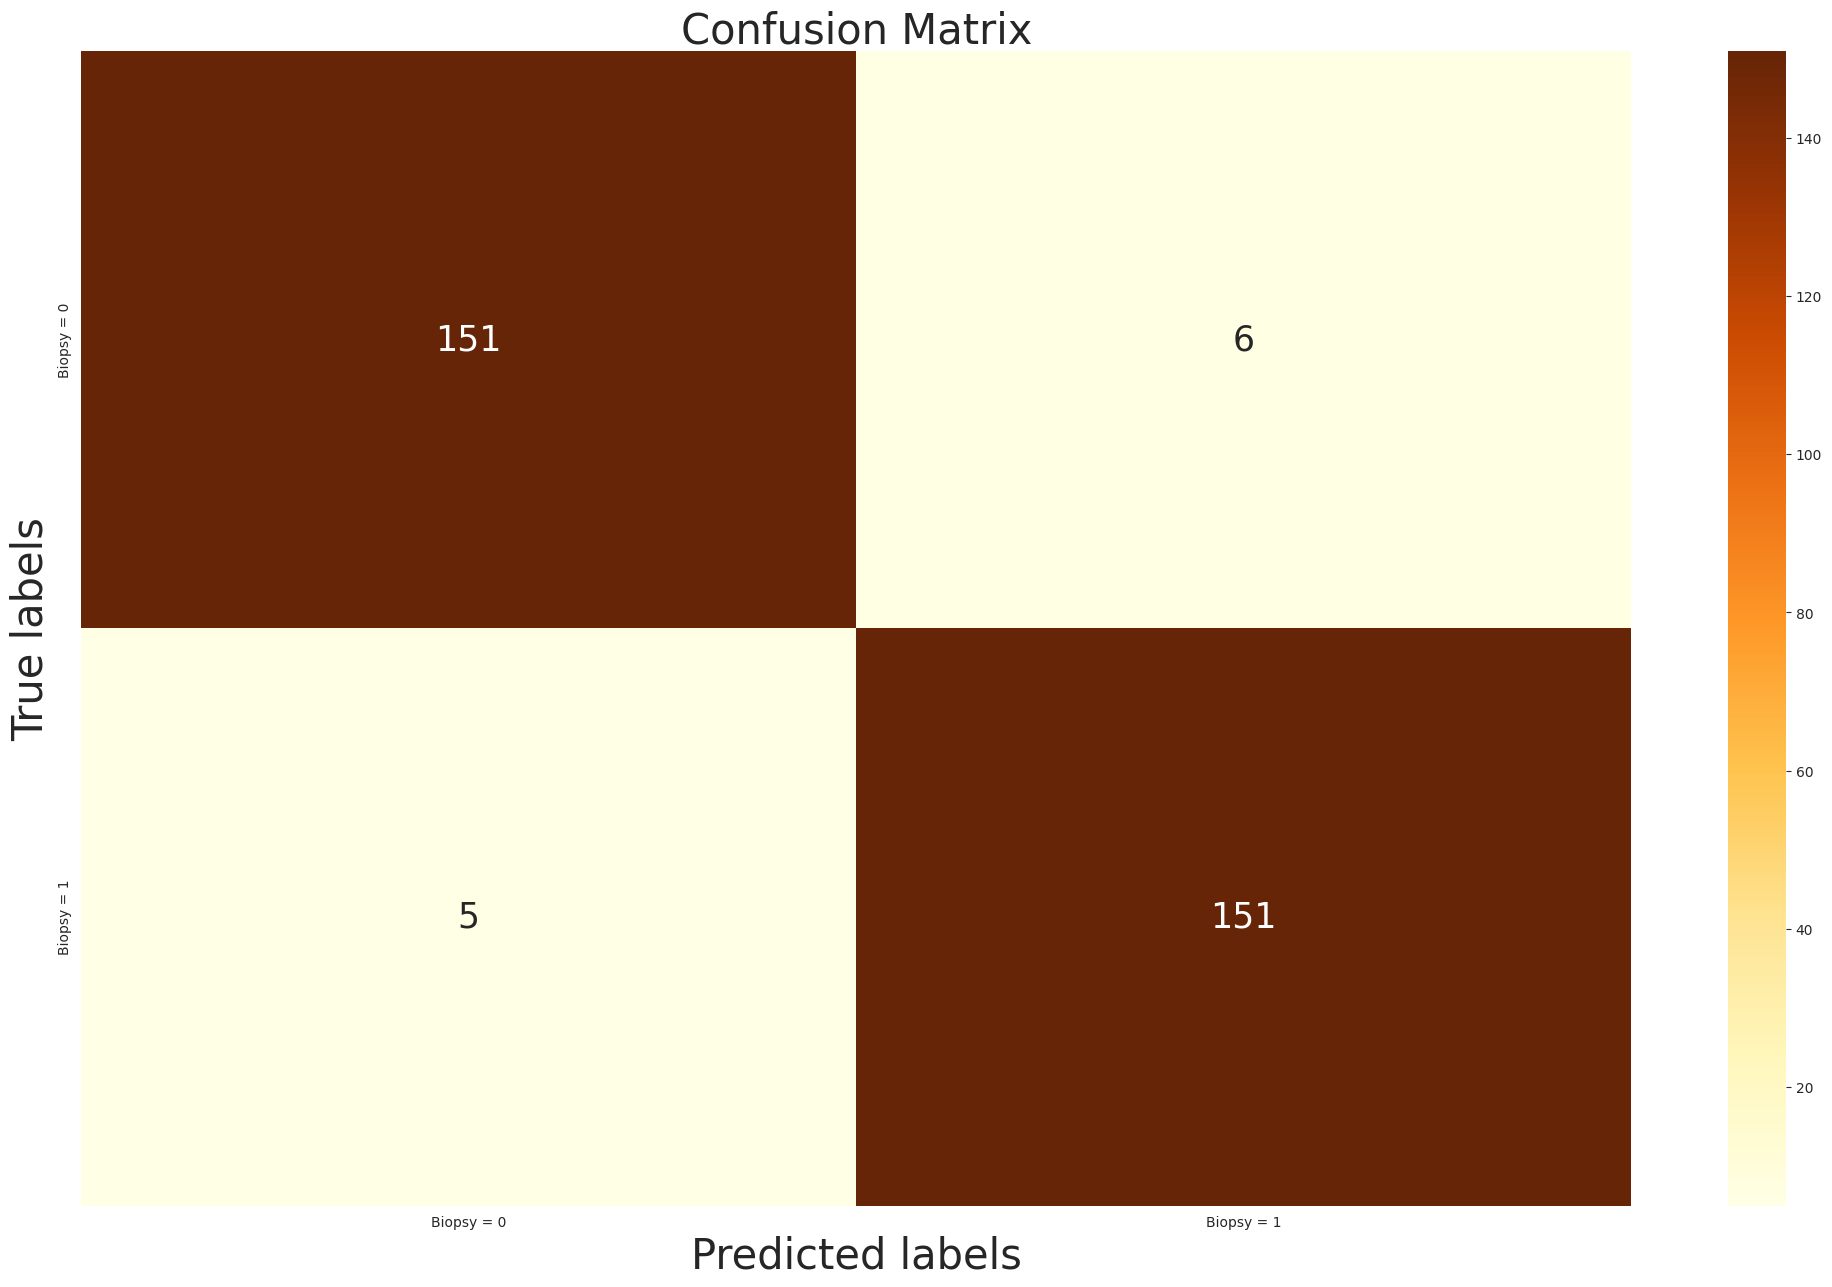

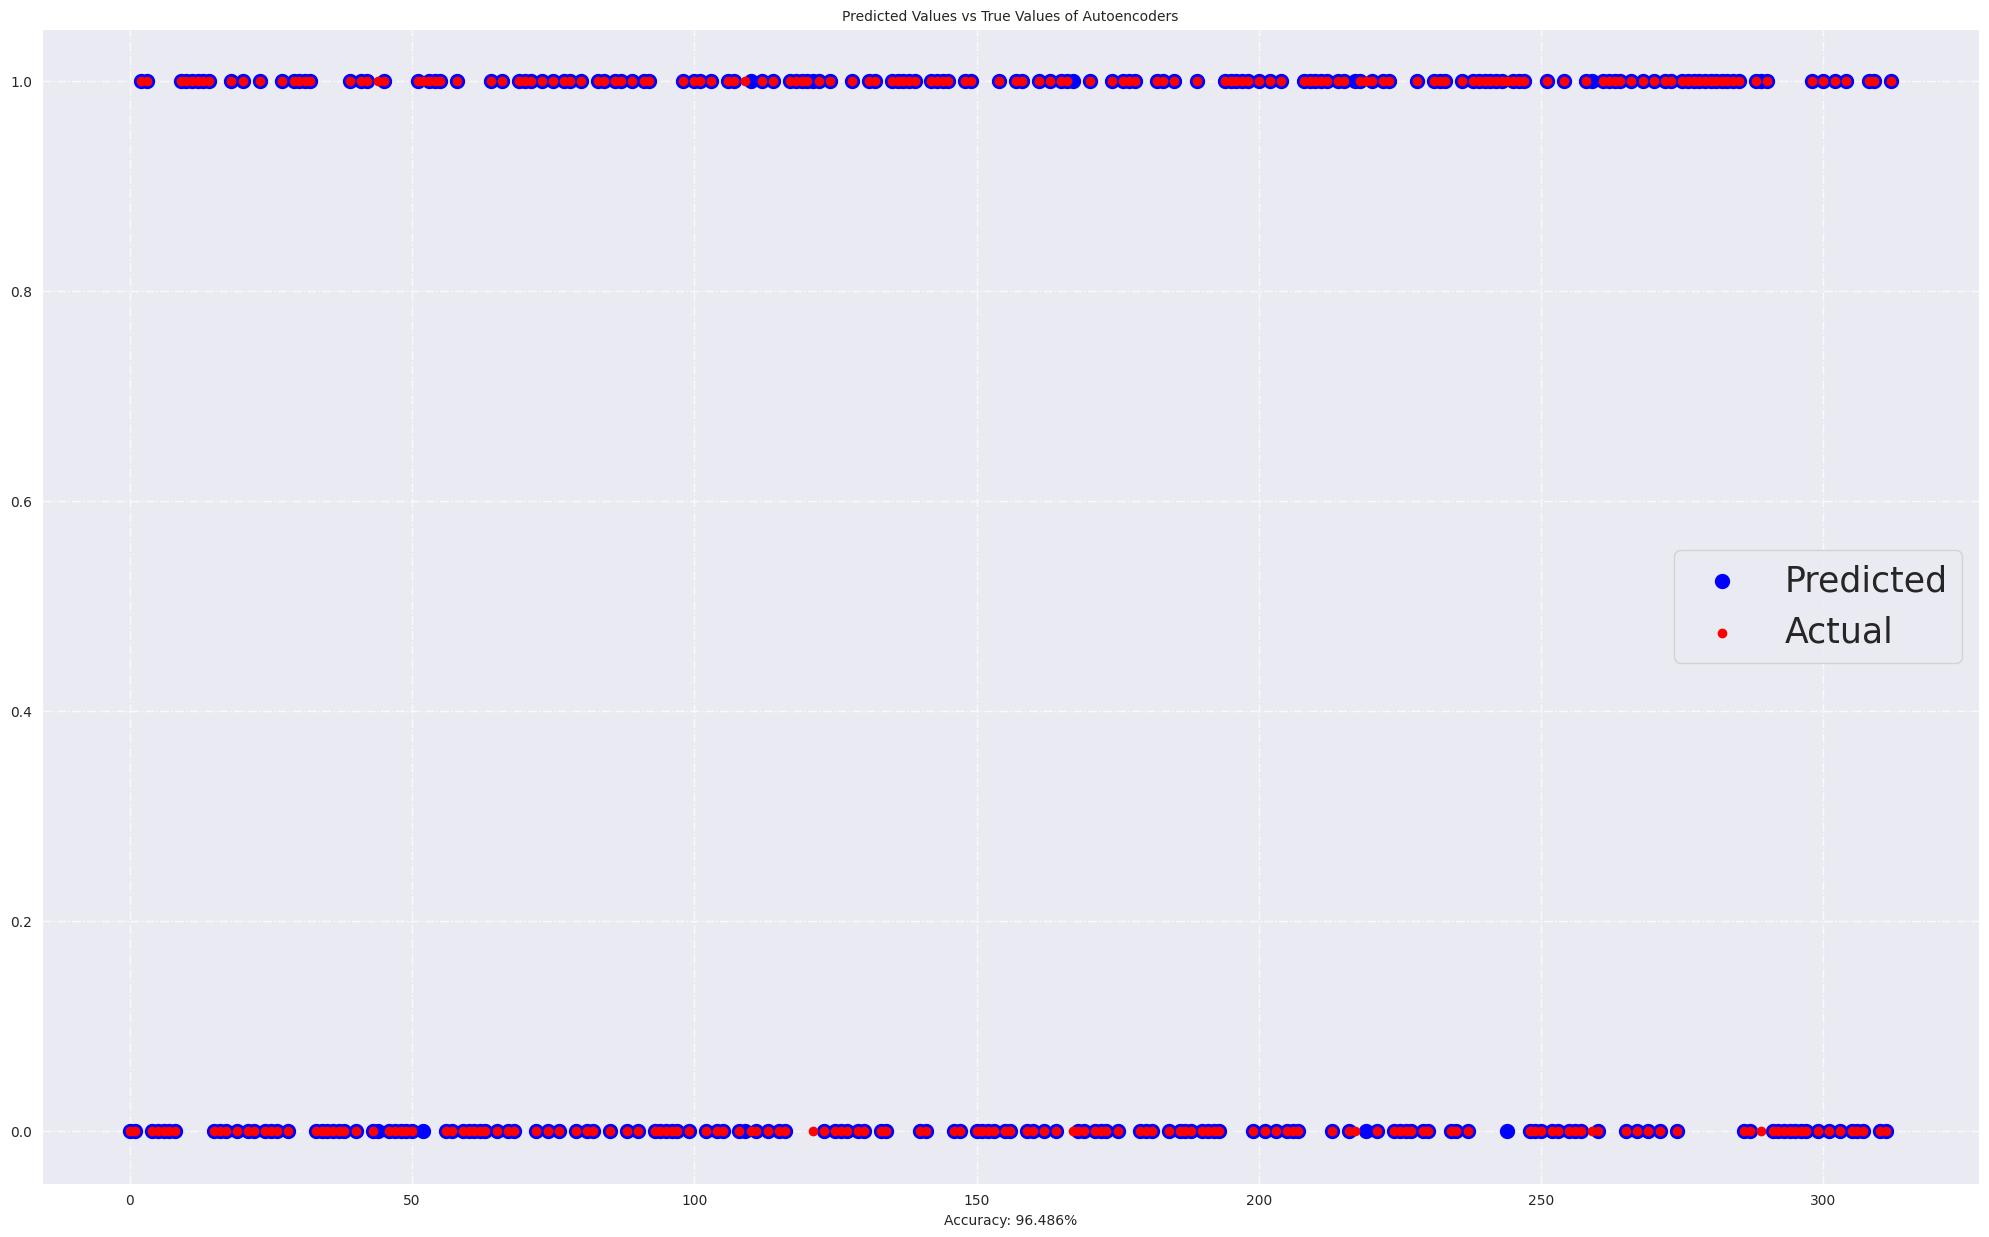

In [20]:
# Autoencoder Model
input_layer = tf.keras.layers.Input(shape=(X_train.shape[1],))
encoder = tf.keras.layers.Dense(units=128, activation='relu')(input_layer)
encoder = tf.keras.layers.Dense(units=64, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(units=32, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(units=64, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(units=128, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(units=X_train.shape[1],activation='linear')(decoder)
autoencoder = tf.keras.models.Model(inputs=input_layer,outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(X_train, X_train, batch_size=64, epochs=100,validation_split=0.2, shuffle=True)
# Transform features using the Autoencoder
encoded_features = autoencoder.predict(X_train)
encoded_features_test = autoencoder.predict(X_test)
# Imports Tensorflow and create a Sequential Model to add a layer for the Logistic Regression
logreg = tf.keras.models.Sequential()
# Input layer
logreg.add(tf.keras.layers.Input(shape=(encoded_features.shape[1],)))
# Output layer
logreg.add(tf.keras.layers.Dense(units=1, kernel_initializer='uniform',activation='sigmoid'))
print(logreg.summary()) # for showing the structure and parameters
# Compiles the Logistic Regression using ADAM optimizer.
logreg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Trains the Logistic Regression with 100 epochs.
logreg_history = logreg.fit(encoded_features, y_train, batch_size=64,validation_split=0.20, epochs=250, shuffle=True)
# Predict using Logistic Regression
y_pred = logreg.predict(encoded_features_test)
y_pred = [int(p >= 0.5) for p in y_pred]
print(y_pred)
# Performance Evaluation - Accuracy and Classification Report
# Accuracy Score
print('Accuracy Score : ', accuracy_score(y_pred, y_test,
normalize=True), '\n')
# Classification Report
print('Classification Report :\n\n', classification_report(y_pred, y_test))
# Plots accuracy and loss
acc = logreg_history.history['accuracy']
val_acc = logreg_history.history['val_accuracy']
loss = logreg_history.history['loss']
val_loss = logreg_history.history['val_loss']
epochs = range(1, len(acc) + 1)
# Accuracy
fig, ax = plt.subplots(figsize=(25, 15))
plt.plot(epochs, acc, 'r', label='Training accuracy', lw=10)
plt.plot(epochs, val_acc, 'b--', label='Validation accuracy', lw=10)
plt.title('Training and validation accuracy', fontsize=35)
plt.legend(fontsize=25)
ax.set_xlabel("Epoch", fontsize=30)
ax.tick_params(labelsize=30)
plt.show()
# Loss
fig, ax = plt.subplots(figsize=(25, 15))
plt.plot(epochs, loss, 'r', label='Training loss', lw=10)
plt.plot(epochs, val_loss, 'b--', label='Validation loss', lw=10)
plt.title('Training and validation loss', fontsize=35)
plt.legend(fontsize=25)
ax.set_xlabel("Epoch", fontsize=30)
ax.tick_params(labelsize=30)
plt.show()
# Confusion matrix:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
class_list = ['Biopsy = 0', 'Biopsy = 1']
fig, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(conf_mat, annot=True, ax=ax, cmap='YlOrBr', fmt='g',annot_kws={"size": 25})
ax.set_xlabel('Predicted labels', fontsize=30)
ax.set_ylabel('True labels', fontsize=30)
ax.set_title('Confusion Matrix', fontsize=30)
ax.xaxis.set_ticklabels(class_list), ax.yaxis.set_ticklabels(class_list)
plt.show()
def plot_real_pred_val(Y_test, ypred, name):
    plt.figure(figsize=(25,15))
    acc=accuracy_score(Y_test,ypred)

    plt.scatter(range(len(ypred)),ypred,color="blue",lw=5,label="Predicted")
    plt.scatter(range(len(Y_test)), Y_test,color="red",label="Actual")
    plt.title("Predicted Values vs True Values of " + name, fontsize=10)
    plt.xlabel("Accuracy: " + str(round((acc*100),3)) + "%")
    plt.legend(fontsize=25)
    plt.grid(True, alpha=0.75, lw=1, ls='-.')
    plt.show()
plot_real_pred_val(y_test, y_pred, 'Autoencoders')